# A Clustering Approach to Evaluate Exercise Needs in Women with Breast Cancer

This notebook cleans and prepares the data for clustering. It creates the files `records-clean.csv` and `demographics-clean.csv`.

In [1]:
# Import global dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, date, timedelta
from math import floor, isnan

# Plot condiguration
plot_scale_factor = 3/4 
plt.rcParams['figure.figsize'] = (16*plot_scale_factor,9*plot_scale_factor)
sns.set_theme(style="whitegrid")

# Fix seed for numpy
np.random.seed(42)

## Load data
Daily records of ATOPE+ measures, and Fitbit's physical activity and sleep, are loaded from `records.csv`. Demographics data are loaded from `demographics.csv.` We only use steps data for "yesterday", since that would be the data available at the time of recommendations.

In [2]:
# Load data
daily_records = pd.read_csv('./data/atope+breast/records.csv')
demographics = pd.read_csv('./data/atope+breast/demographics.csv')

## Data cleaning and preprocessing
### Define cleaning functions
We first define functions to find and replace inter-quartile range (IQR) outliers.

In [3]:
# Define function for IQR outlier detection and knn-replacement
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler

def replace_iqr_outliers_knn(data, iqr_variable, knn_columns):
       """replace_iqr_outliers_knn

       Detects IQR outliers and replaces them with KNN.
       """
       
       # IQR detection
       q1 = data[iqr_variable].quantile(0.25)
       q3 = data[iqr_variable].quantile(0.75)
       iqr = q3 - q1
       outliers_iqr = (data[iqr_variable] < (q1 - 1.5*iqr)) | (data[iqr_variable] > (q3 + 1.5*iqr))
       print('Outliers for ' + iqr_variable + ': ' + str(outliers_iqr.sum()))

       if outliers_iqr.sum() == 0:
              return np.nan, np.nan

       # Plot without outliers
       fig, ax = plt.subplots(3,1)
       data.loc[:, iqr_variable].hist(bins=100, ax=ax[0])
       ax[0].set_title('Original ' + iqr_variable)
       data.loc[~outliers_iqr, iqr_variable].hist(bins=100, ax=ax[1])
       ax[1].set_title('Remove outliers for '+ iqr_variable)

       # Replace outliers
       data.loc[outliers_iqr, iqr_variable] = np.nan  # first set to NaN

       # KNN model
       model = KNeighborsRegressor(n_neighbors=3)

       # Transform categorical variable and Standardization
       if 'username' in knn_columns:
              data['username'] = LabelEncoder().fit_transform(y = data['username'].values)
       data.loc[:, knn_columns].apply(lambda s: (s - s.mean())/s.std())

       x_test = data.loc[outliers_iqr, knn_columns].dropna().values

       if x_test.shape[0]>0:
              train = data.loc[~outliers_iqr, knn_columns + [iqr_variable]]
              x_train = train.loc[:, knn_columns].values
              y_train = train.loc[:, iqr_variable].values

              model.fit(x_train, y_train)
              y_input = model.predict(x_test)
       
       else:
              x_test = data.loc[outliers_iqr, knn_columns].dropna(axis=1).values
              columns_dropna = data.loc[outliers_iqr, knn_columns].dropna(axis=1).columns.values.tolist()
              print('Selected columns for '+iqr_variable+': '+str(columns_dropna))
              train = data.loc[~outliers_iqr, columns_dropna + [iqr_variable]]
              
              x_train = train.dropna().loc[:, columns_dropna].values
              y_train = train.dropna().loc[:, iqr_variable].values

              model.fit(x_train, y_train)
              y_input = model.predict(x_test)
              

       # Replace
       data.loc[outliers_iqr, iqr_variable] = y_input

       # replacers_max_hr = data.loc[~outliers_iqr, ['max_hr','username']].groupby('username').median()
       # for u in replacers_max_hr.index.values:
       #     selected_user = (data['username'] == u)
       #     input_max_hr = replacers_max_hr.loc[u,:][0]
       #     data.loc[(outliers_iqr & selected_user), 'max_hr'] = input_max_hr

       data.loc[:, iqr_variable].hist(bins=100,ax=ax[2])
       ax[2].set_title(iqr_variable + ' after inputation')#replacers_max_hr[u]
       print('Outliers replaced for ' + iqr_variable + ': ' + str(len(y_input)))
       fig.tight_layout()

       # Replace in original dataset
       outliers_index_original_data = outliers_iqr.index[outliers_iqr.values] # Keep index marked as True (outliers)
       # (DO THIS OUTSIDE FUNCTION TO REPLACE IN ORIGINAL DATASET)
       # daily_records.loc[outliers_index_original_data, iqr_variable] = data.loc[:,iqr_variable]
       return data.loc[:,iqr_variable], outliers_index_original_data



# TODO: USE FOR SWC ¿AND CV?
def replace_iqr_outliers_uniform(data, iqr_variable, lower_range, upper_range):
       """replace_iqr_outliers_uniform

       Detects IQR outliers and replaces them with uniform distributions.
       """
       
       # IQR detection
       q1 = data[iqr_variable].quantile(0.25)
       q3 = data[iqr_variable].quantile(0.75)
       iqr = q3 - q1

       outliers_upper_iqr = (data[iqr_variable] > (q3 + 1.5*iqr))
       outliers_lower_iqr = (data[iqr_variable] < (q1 - 1.5*iqr))
       
       outliers_iqr = outliers_lower_iqr | outliers_upper_iqr
       print('Outliers for ' + iqr_variable + ': ' + str(outliers_iqr.sum()))

       if outliers_iqr.sum() == 0:
              return np.nan, np.nan

       # Plot without outliers
       fig, ax = plt.subplots(3,1)
       data.loc[:, iqr_variable].hist(bins=100, ax=ax[0])
       ax[0].set_title('Original ' + iqr_variable)
       data.loc[~outliers_iqr, iqr_variable].hist(bins=100, ax=ax[1])
       ax[1].set_title('Remove outliers for '+ iqr_variable)

       # Replace outliers
       data.loc[outliers_iqr, iqr_variable] = np.nan  # first set to NaN

       # Distributions
       input_upper = np.random.uniform(upper_range[0], upper_range[1], outliers_upper_iqr.sum())
       input_lower = np.random.uniform(lower_range[0], lower_range[1], outliers_lower_iqr.sum())            

       # Replace
       data.loc[outliers_upper_iqr, iqr_variable] = input_upper
       data.loc[outliers_lower_iqr, iqr_variable] = input_lower


       # Plot
       data.loc[:, iqr_variable].hist(bins=100,ax=ax[2])
       ax[2].set_title(iqr_variable + ' after inputation')#replacers_max_hr[u]
       print('Outliers replaced for ' + iqr_variable + ': ' + str(outliers_iqr.sum()))
       fig.tight_layout()

       # Replace in original dataset
       outliers_index_original_data = outliers_iqr.index[outliers_iqr.values] # Keep index marked as True (outliers)
       # (DO THIS OUTSIDE FUNCTION TO REPLACE IN ORIGINAL DATASET)
       # daily_records.loc[outliers_index_original_data, iqr_variable] = data.loc[:,iqr_variable]
       return data.loc[:,iqr_variable], outliers_index_original_data
       

### Filter by complete HRV measures
Complete HRV measures need at least 5 measures recorded in the previous 7 days. These measures are the ones without NA values for the variables `cv_lnrmssd` and `swc_lnrmssd`.

In [4]:
# Only variables with enough days to compute CV and SWC for lnrmssd
valid_hrv_measures = daily_records.loc[:,'cv_lnrmssd'].notna() & daily_records.loc[:,'swc_lnrmssd'].notna()

### Univariate Visual Exploration
Plot univariate distributions in histograms for visual inspection.

/home/dollo/Workspace/atope-analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


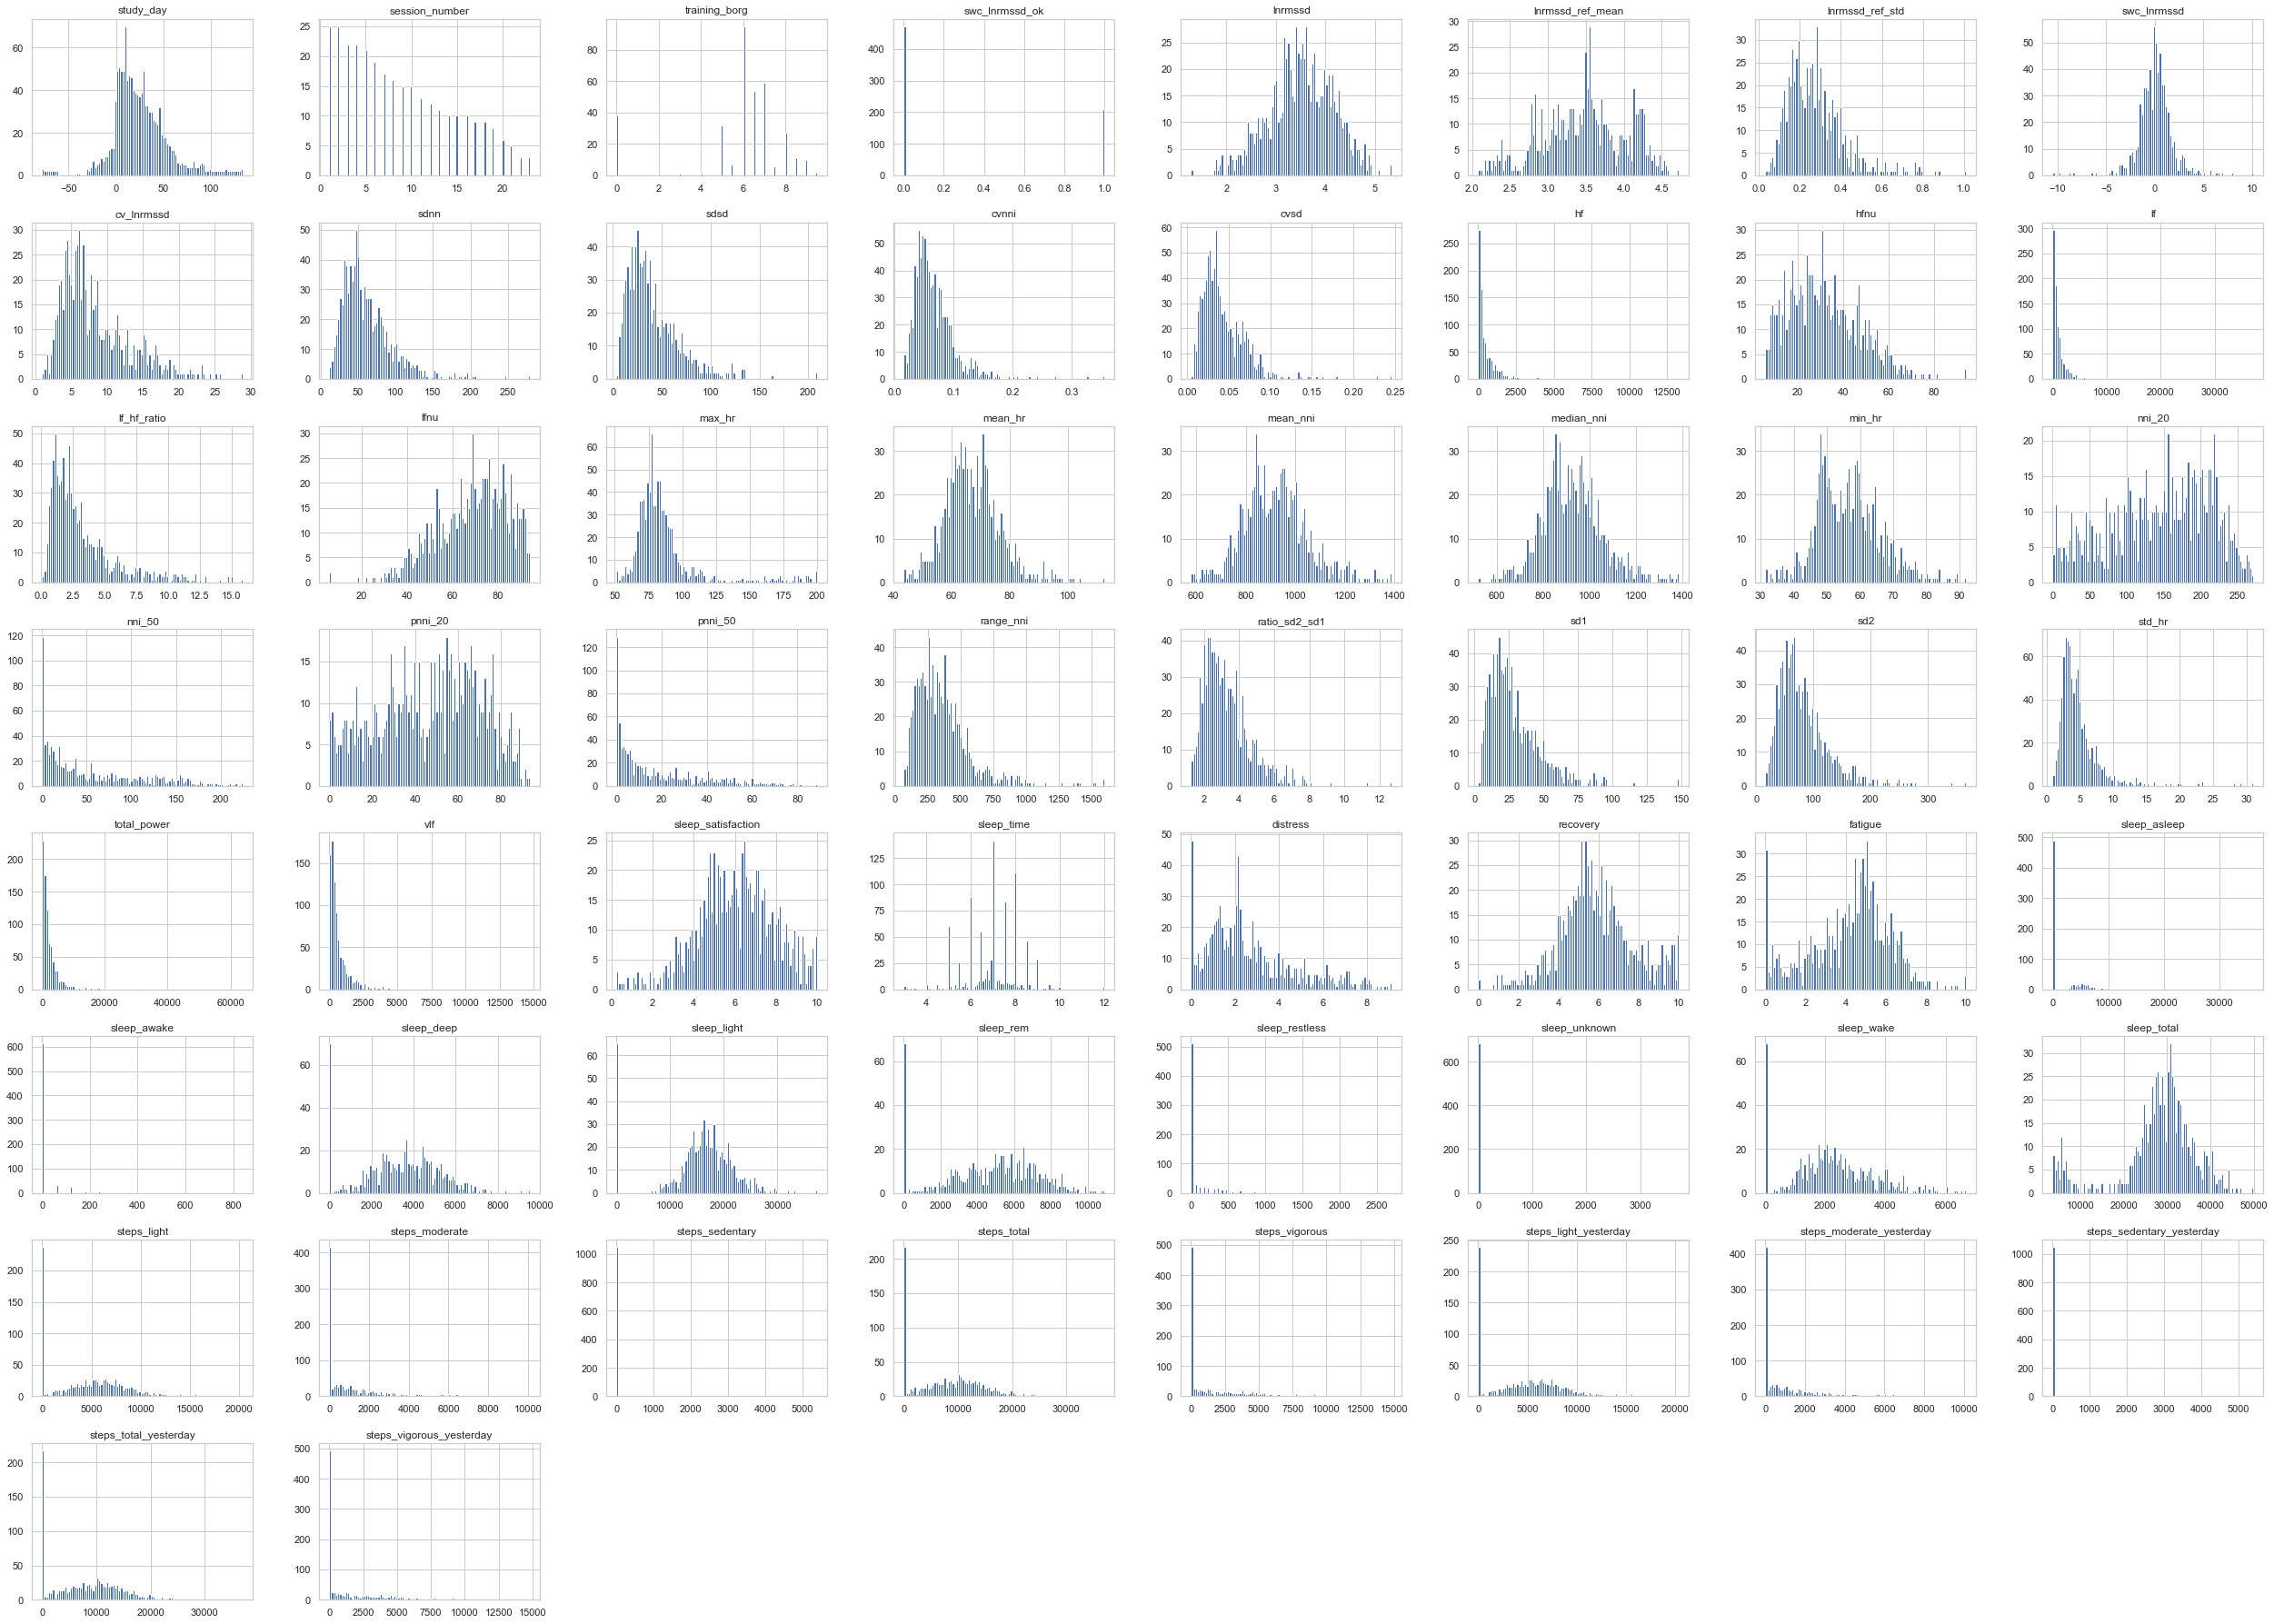

In [5]:
# Plot histogram for variables
fig, ax = plt.subplots(figsize=(44,32))
fig = daily_records.hist(bins=100, ax=ax)

### Compute Skewness
The presence of skewness is not recommended for clustering analysis since it may bias group formation. Hence, we compute skewness for all continuous variables in our dataset.

If skewness value lies above +1 or below -1, data is highly skewed. If it lies between +0.5 to -0.5, it is moderately skewed. If the value is 0, then the data is symmetric. Common transformations of possitively- or left-skewed data are square root, cube root and logarithm. Common transformations of negatively- or right-skewed data are squares, cubes or higher powers. To avoid skew when looking for clusters, logarithm is applied to the following distributions:

In [6]:
from scipy.stats import skew

# Compute skewness for all possible columns (categorical variables are removed)
categorical_columns = ['username', 'study_day', 'session_type', 'session_number',
       'training_borg', 'swc_lnrmssd_ok', 'cv_lnrmssd_ok']
skewness_columns = daily_records.loc[valid_hrv_measures,:].drop(
    categorical_columns, axis=1).apply(lambda srs: skew(srs.dropna()))

print(skewness_columns[(skewness_columns>1) | (skewness_columns<-1)])
print(skewness_columns[(skewness_columns>1) | (skewness_columns<-1)].index)

# Variables not included after visual inspection:
#  - lnrmssd_ref_std: long tail in the right, may be outliers. 
#  - max_hr: long tail in the right, certainly outliers, values are too high for
#            resting position.
#  - pnni_50: many values are 0 (like nni_50)
#  - All fitbit variables due to many values in 0: 'sleep_asleep', 'sleep_awake', 'sleep_restless', 'sleep_unknown', 'sleep_total', 'steps_moderate', 'steps_sedentary', 'steps_vigorous', 'steps_moderate_yesterday', 'steps_sedentary_yesterday', 'steps_vigorous_yesterday'
# All the accumulation of Fitbit data in zero are impossible to equilibrate, thus no transformation is applied to Fitbit data that will benefit the clustering. The total  measures seem ok despite the accumulation of zero values after manual examination.

lnrmssd_ref_std              1.422185
cv_lnrmssd                   1.136504
sdnn                         1.879143
sdsd                         1.788640
cvnni                        2.744796
cvsd                         2.412590
hf                           6.947298
lf                           8.583006
lf_hf_ratio                  1.725129
max_hr                       2.662872
pnni_50                      1.090393
range_nni                    2.137389
ratio_sd2_sd1                1.622574
sd1                          1.786248
sd2                          1.934088
std_hr                       3.760638
total_power                  7.693660
vlf                          5.749820
distress                     1.031136
sleep_asleep                 3.196909
sleep_awake                  5.062548
sleep_light                 -1.007046
sleep_restless               3.896233
sleep_unknown                9.661163
steps_moderate               1.519831
steps_sedentary              9.428683
steps_vigoro

In [7]:
# HRV skew
skewdf = pd.DataFrame(skewness_columns, columns=['skewness'])
print((skewdf.loc[['lnrmssd', 'lnrmssd_ref_mean', 'lnrmssd_ref_std', 'swc_lnrmssd',
       'cv_lnrmssd', 'sdnn', 'sdsd', 'cvnni', 'cvsd', 'hf', 'hfnu', 'lf',
       'lf_hf_ratio', 'lfnu', 'max_hr', 'mean_hr', 'mean_nni', 'median_nni',
       'min_hr', 'nni_20', 'nni_50', 'pnni_20', 'pnni_50', 'range_nni',
       'ratio_sd2_sd1', 'sd1', 'sd2', 'std_hr', 'total_power', 'vlf'],:].round(2)))

\begin{tabular}{lr}
\toprule
{} &  skewness \\
\midrule
lnrmssd          &     -0.26 \\
lnrmssd\_ref\_mean &     -0.19 \\
lnrmssd\_ref\_std  &      1.42 \\
swc\_lnrmssd      &     -0.23 \\
cv\_lnrmssd       &      1.14 \\
sdnn             &      1.88 \\
sdsd             &      1.79 \\
cvnni            &      2.74 \\
cvsd             &      2.41 \\
hf               &      6.95 \\
hfnu             &      0.60 \\
lf               &      8.58 \\
lf\_hf\_ratio      &      1.73 \\
lfnu             &     -0.60 \\
max\_hr           &      2.66 \\
mean\_hr          &      0.64 \\
mean\_nni         &      0.39 \\
median\_nni       &      0.37 \\
min\_hr           &      0.43 \\
nni\_20           &     -0.35 \\
nni\_50           &      0.95 \\
pnni\_20          &     -0.21 \\
pnni\_50          &      1.09 \\
range\_nni        &      2.14 \\
ratio\_sd2\_sd1    &      1.62 \\
sd1              &      1.79 \\
sd2              &      1.93 \\
std\_hr           &      3.76 \\
total\_power      &      7.

### Clean HRV data
Now that all HRV variables are the most similar to a normal distribution, we replace IQR outliers with KNN.

In [8]:
# Variables not included after visual inspection:
#  - lnrmssd_ref_std: long tail in the right, may be outliers. 
#  - max_hr: long tail in the right, certainly outliers, values are too high for
#            resting position.
#  - pnni_50: many values are 0 (like nni_50)
#  - All fitbit variables due to many values in 0: 'sleep_asleep', 'sleep_awake', 'sleep_restless', 'sleep_unknown', 'sleep_total', 'steps_moderate', 'steps_sedentary', 'steps_vigorous', 'steps_moderate_yesterday', 'steps_sedentary_yesterday', 'steps_vigorous_yesterday'
# All the accumulation of Fitbit data in zero are impossible to equilibrate, thus no transformation is applied to Fitbit data that will benefit the clustering. The total  measures seem ok despite the accumulation of zero values after manual examination.

column_skewness_hrv_log = ['cv_lnrmssd', 'sdnn', 'sdsd', 
    'cvnni', 'cvsd', 'hf', 'lf', 'lf_hf_ratio', 'range_nni', 'ratio_sd2_sd1',
       'sd1', 'sd2', 'std_hr', 'total_power', 'vlf']

column_skewness_hrv_power = ['lfnu']

#### Clean Maximum Heart Rate
After finding IQR outliers and replacing them with KNN the new skewness of the distribution does not require to apply logarithm.

/home/dollo/Workspace/atope-analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


Outliers for max_hr: 50
Selected columns for max_hr: ['lnrmssd', 'lnrmssd_ref_mean', 'lnrmssd_ref_std', 'swc_lnrmssd', 'cv_lnrmssd', 'sdnn', 'sdsd', 'cvnni', 'cvsd', 'hf', 'hfnu', 'lf', 'lf_hf_ratio', 'lfnu', 'mean_hr', 'mean_nni', 'median_nni', 'min_hr', 'nni_20', 'nni_50', 'pnni_20', 'pnni_50', 'range_nni', 'ratio_sd2_sd1', 'sd1', 'sd2', 'std_hr', 'total_power', 'vlf', 'sleep_satisfaction', 'sleep_time', 'distress', 'recovery', 'fatigue']
Outliers replaced for max_hr: 50
New skew for max_hr: 0.3702926694950416


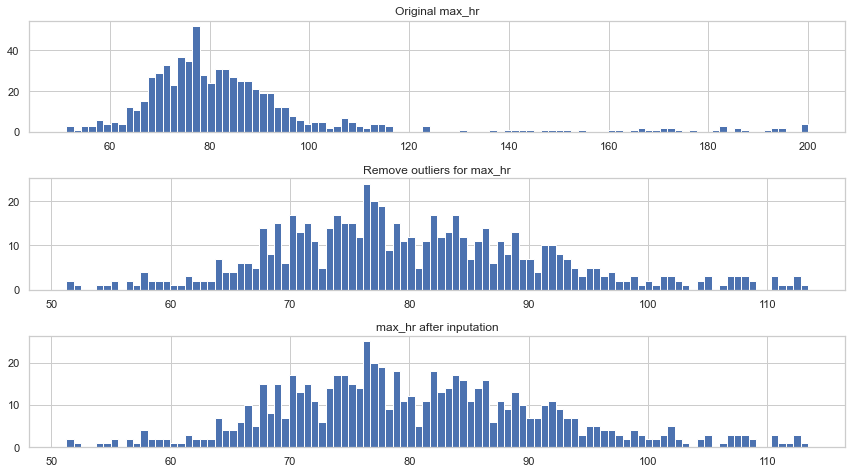

In [9]:
# Work on copy for safety
df = daily_records.loc[valid_hrv_measures,:].copy()

# HRV variables to clean
hrv_clean_variables = ['max_hr']

# Only HRV and wellness variables are used to input KNN
knn_columns = ['lnrmssd', 'lnrmssd_ref_mean', 'lnrmssd_ref_std', 'swc_lnrmssd', 
       'cv_lnrmssd', 'sdnn', 'sdsd', 'cvnni', 'cvsd', 'hf', 'hfnu', 'lf', 
       'lf_hf_ratio', 'lfnu', 'max_hr', 'mean_hr', 'mean_nni', 'median_nni', 
       'min_hr', 'nni_20', 'nni_50', 'pnni_20', 'pnni_50', 'range_nni', 
       'ratio_sd2_sd1', 'sd1', 'sd2', 'std_hr', 'total_power', 'vlf', 
       'sleep_satisfaction', 'sleep_time', 'distress', 'recovery', 'fatigue',]

outliers_summary = pd.Series() # to include summary of outlier input in each variable

for iqr_variable in hrv_clean_variables:
       knn_columns_selected = knn_columns.copy()
       if iqr_variable in knn_columns_selected:
              knn_columns_selected.remove(iqr_variable)
       
       input_data, outliers_index_in_original_data = replace_iqr_outliers_knn(data=df, iqr_variable=iqr_variable, knn_columns=knn_columns)
       if type(input_data) == pd.core.series.Series:
              daily_records.loc[outliers_index_in_original_data, iqr_variable] = input_data
              outliers_summary[iqr_variable] = len(outliers_index_in_original_data)
       else:
              outliers_summary[iqr_variable] = 0

       s = skew(daily_records.loc[valid_hrv_measures, iqr_variable])
       print('New skew for '+iqr_variable+': '+str(s))

#### Transform data
Transform with log to remove skewness

In [10]:
# Transform data
# Log transform for left-skwed distributions
daily_records[column_skewness_hrv_log] = \
    daily_records[column_skewness_hrv_log].apply(np.log)
# Square transform for left-skwed distributions
daily_records[column_skewness_hrv_power] = \
    daily_records[column_skewness_hrv_power].apply(lambda srs: srs**2)


/home/dollo/Workspace/atope-analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


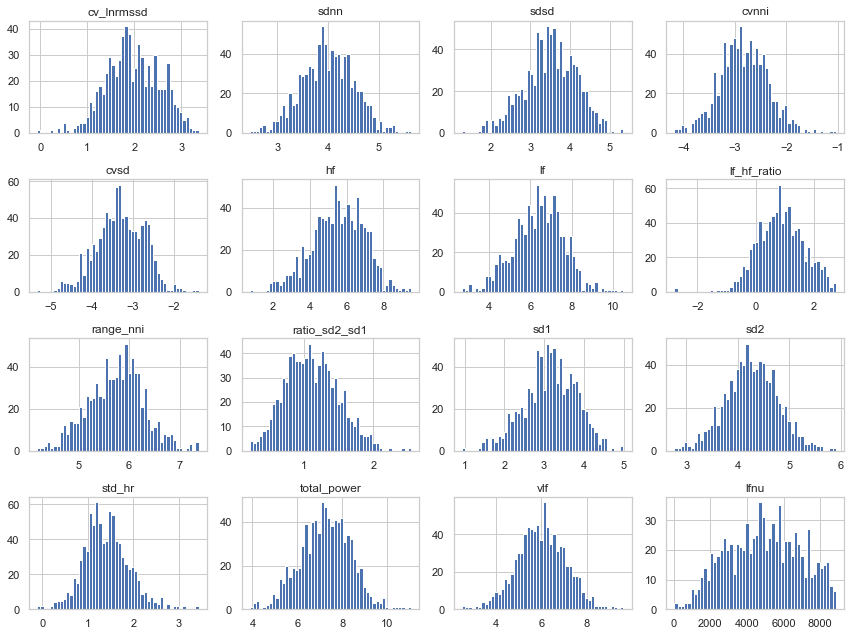

In [11]:
# Plot histogram for visual analysis
fig, ax = plt.subplots(figsize=(12,9))
daily_records[column_skewness_hrv_log+column_skewness_hrv_power].hist(bins=50, ax=ax)
fig.tight_layout()
fig.savefig('viz/transformations-hrv.pdf',  bbox_inches='tight')

#### Acute variables
Variables measured that day

Outliers for lnrmssd: 3
Selected columns for lnrmssd: ['lnrmssd_ref_mean', 'lnrmssd_ref_std', 'swc_lnrmssd', 'cv_lnrmssd', 'sdnn', 'sdsd', 'cvnni', 'cvsd', 'hf', 'hfnu', 'lf', 'lf_hf_ratio', 'lfnu', 'max_hr', 'mean_hr', 'mean_nni', 'median_nni', 'min_hr', 'nni_20', 'nni_50', 'pnni_20', 'pnni_50', 'range_nni', 'ratio_sd2_sd1', 'sd1', 'sd2', 'std_hr', 'total_power', 'vlf', 'sleep_satisfaction', 'sleep_time', 'distress', 'recovery', 'fatigue']
Outliers replaced for lnrmssd: 3
Outliers for lnrmssd_ref_mean: 0
Outliers for lnrmssd_ref_std: 26
Selected columns for lnrmssd_ref_std: ['lnrmssd', 'lnrmssd_ref_mean', 'swc_lnrmssd', 'cv_lnrmssd', 'sdnn', 'sdsd', 'cvnni', 'cvsd', 'hf', 'hfnu', 'lf', 'lf_hf_ratio', 'lfnu', 'max_hr', 'mean_hr', 'mean_nni', 'median_nni', 'min_hr', 'nni_20', 'nni_50', 'pnni_20', 'pnni_50', 'range_nni', 'ratio_sd2_sd1', 'sd1', 'sd2', 'std_hr', 'total_power', 'vlf', 'sleep_satisfaction', 'sleep_time', 'distress', 'recovery', 'fatigue']
Outliers replaced for lnrmssd_ref_s

/home/dollo/Workspace/atope-analysis/venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Selected columns for std_hr: ['lnrmssd', 'lnrmssd_ref_mean', 'lnrmssd_ref_std', 'swc_lnrmssd', 'cv_lnrmssd', 'sdnn', 'sdsd', 'cvnni', 'cvsd', 'hf', 'hfnu', 'lf', 'lf_hf_ratio', 'lfnu', 'max_hr', 'mean_hr', 'mean_nni', 'median_nni', 'min_hr', 'nni_20', 'nni_50', 'pnni_20', 'pnni_50', 'range_nni', 'ratio_sd2_sd1', 'sd1', 'sd2', 'total_power', 'vlf', 'sleep_satisfaction', 'sleep_time', 'distress', 'recovery', 'fatigue']
Outliers replaced for std_hr: 19
Outliers for total_power: 6
Selected columns for total_power: ['lnrmssd', 'lnrmssd_ref_mean', 'lnrmssd_ref_std', 'swc_lnrmssd', 'cv_lnrmssd', 'sdnn', 'sdsd', 'cvnni', 'cvsd', 'hf', 'hfnu', 'lf', 'lf_hf_ratio', 'lfnu', 'max_hr', 'mean_hr', 'mean_nni', 'median_nni', 'min_hr', 'nni_20', 'nni_50', 'pnni_20', 'pnni_50', 'range_nni', 'ratio_sd2_sd1', 'sd1', 'sd2', 'std_hr', 'vlf', 'sleep_satisfaction', 'sleep_time', 'distress', 'recovery', 'fatigue']
Outliers replaced for total_power: 6
Outliers for vlf: 14
Selected columns for vlf: ['lnrmssd', '

max_hr              50
lnrmssd              3
lnrmssd_ref_mean     0
lnrmssd_ref_std     26
sdnn                 3
sdsd                 3
cvnni                8
cvsd                 5
hf                   1
hfnu                 4
lf                   9
lf_hf_ratio          3
lfnu                 0
mean_hr             17
mean_nni            10
median_nni          12
min_hr               8
nni_20               0
nni_50               4
pnni_20              0
pnni_50              9
range_nni            9
ratio_sd2_sd1        3
sd1                  3
sd2                  6
std_hr              19
total_power          6
vlf                 14
dtype: int64

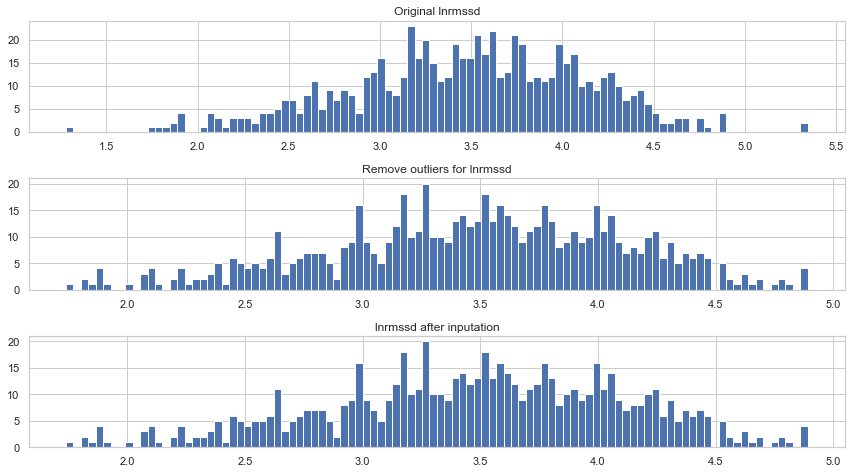

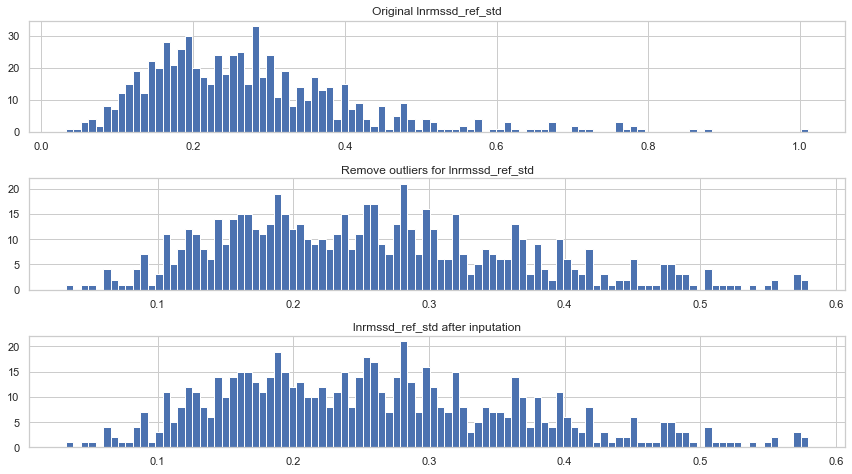

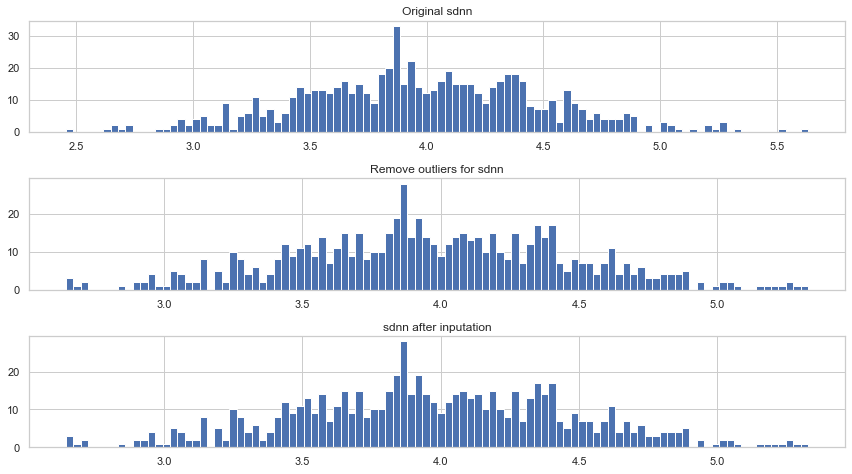

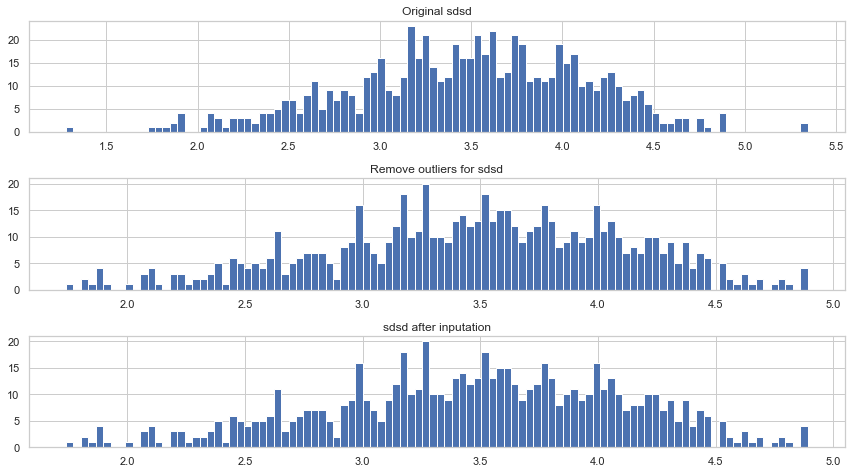

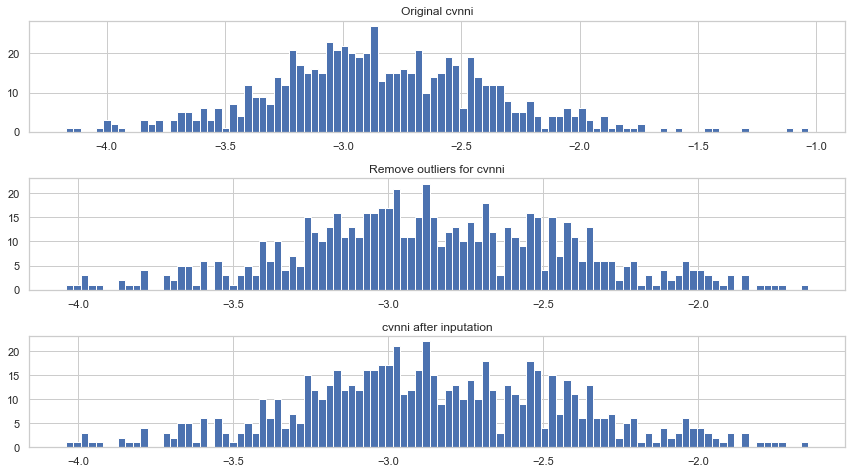

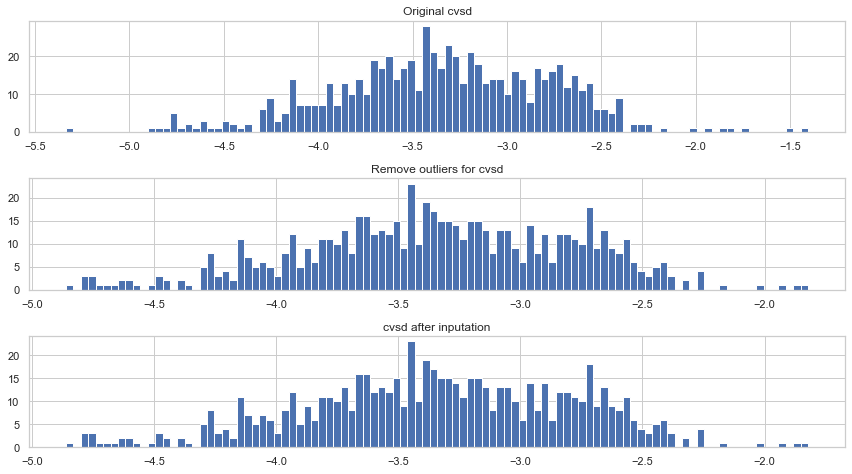

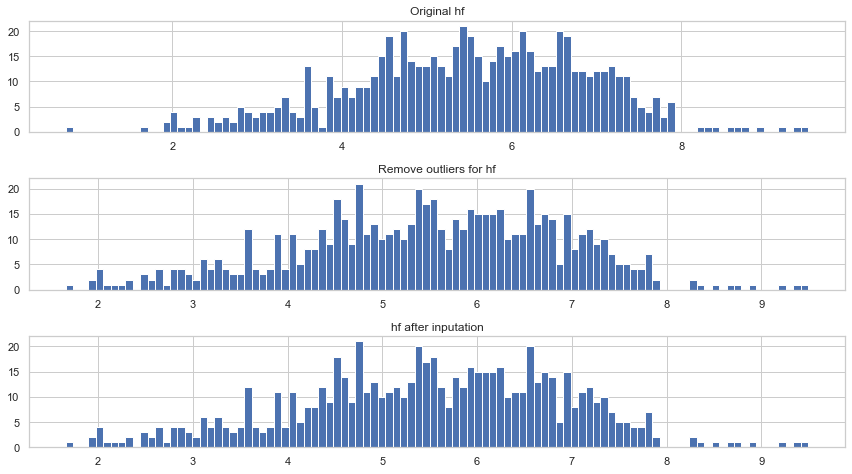

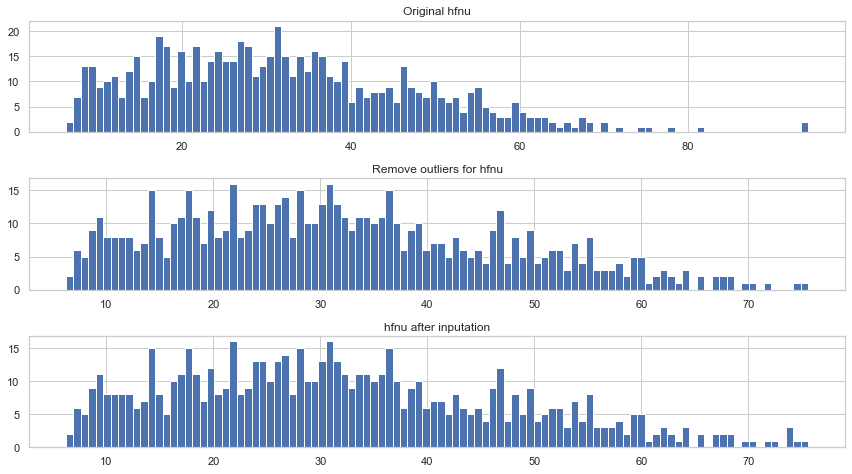

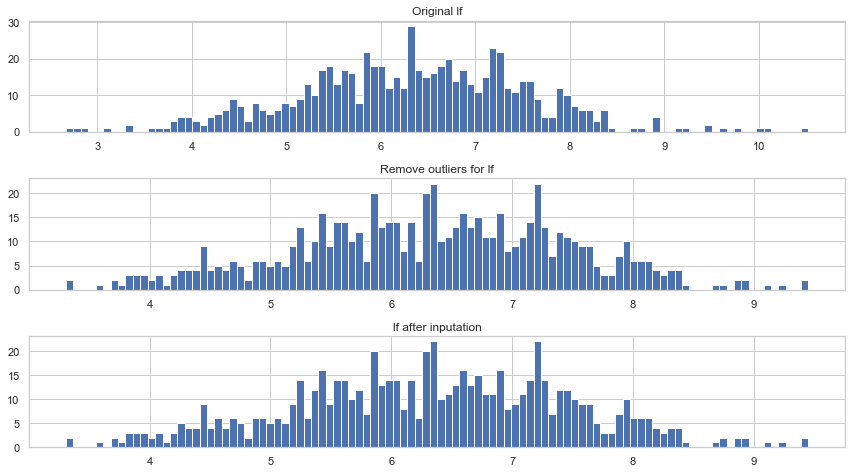

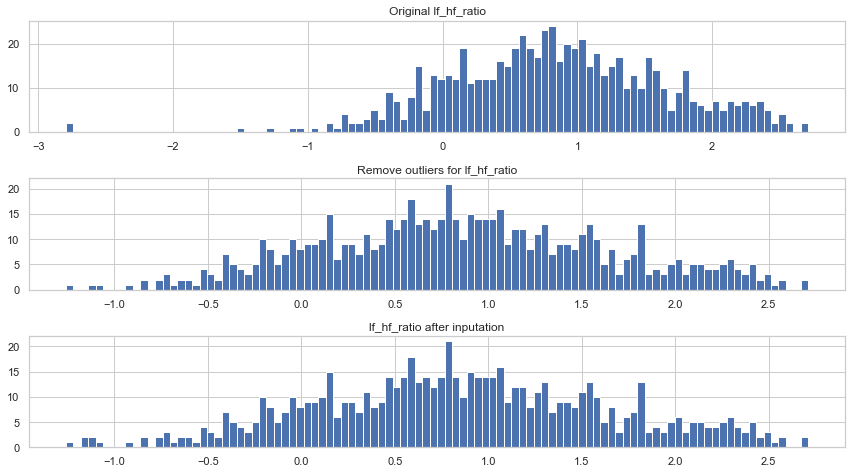

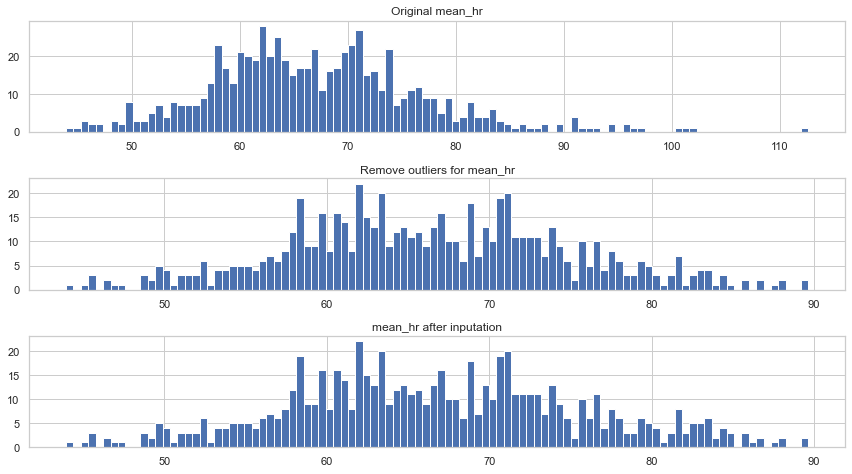

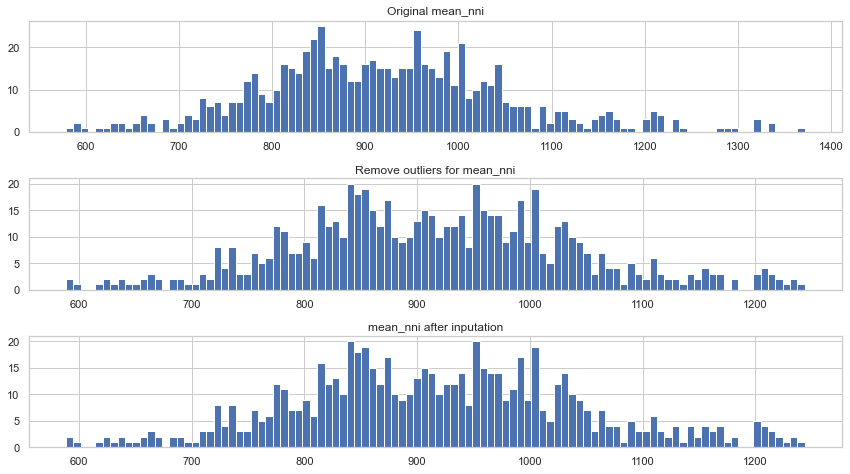

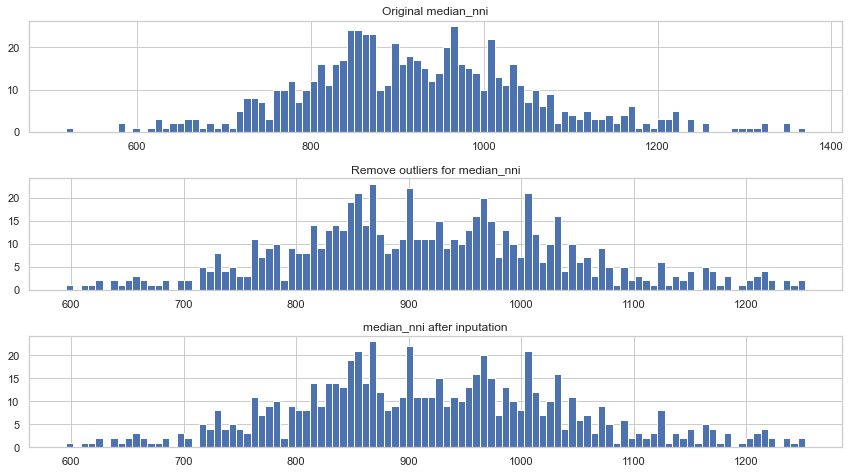

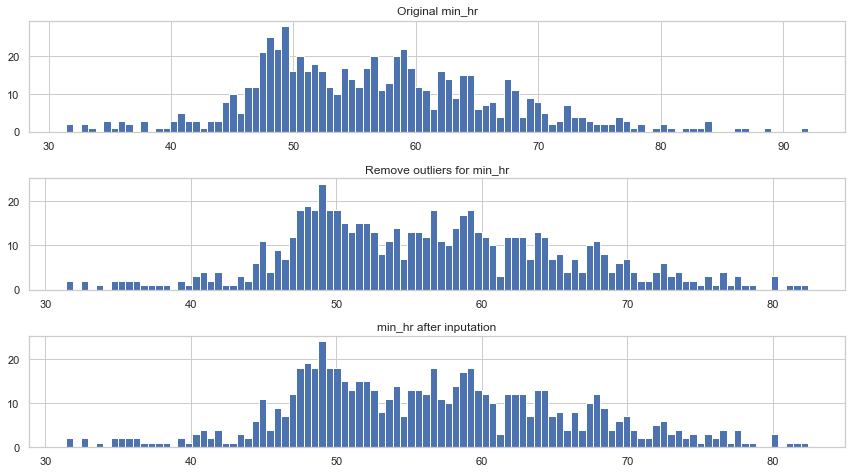

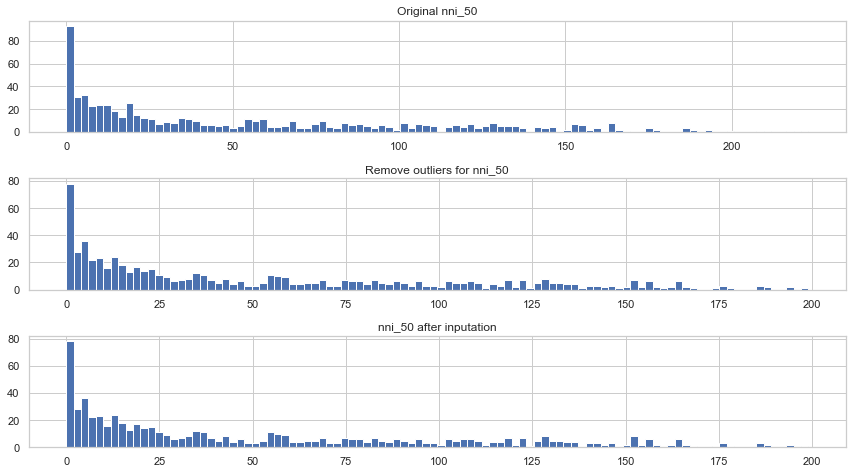

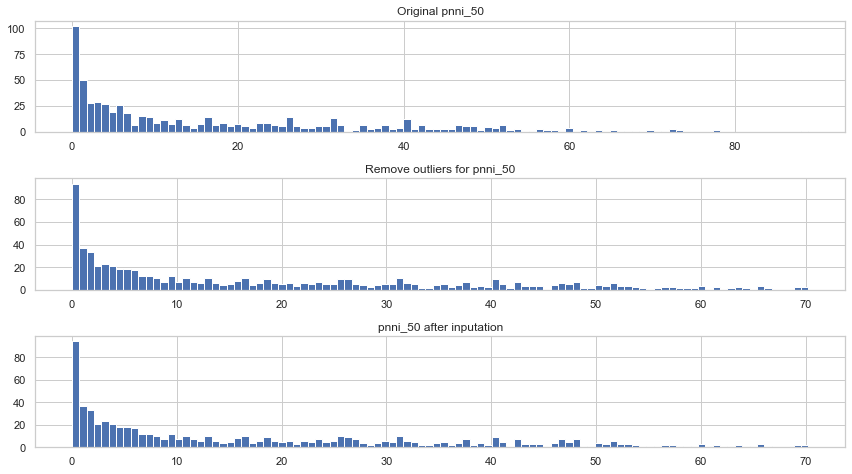

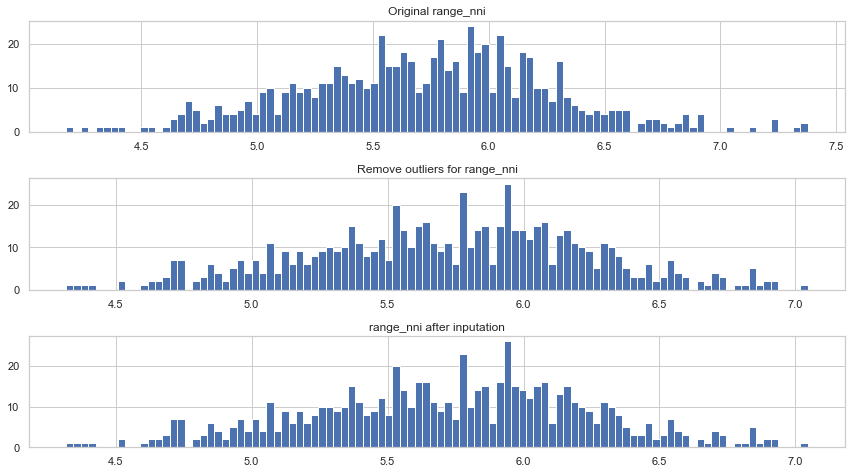

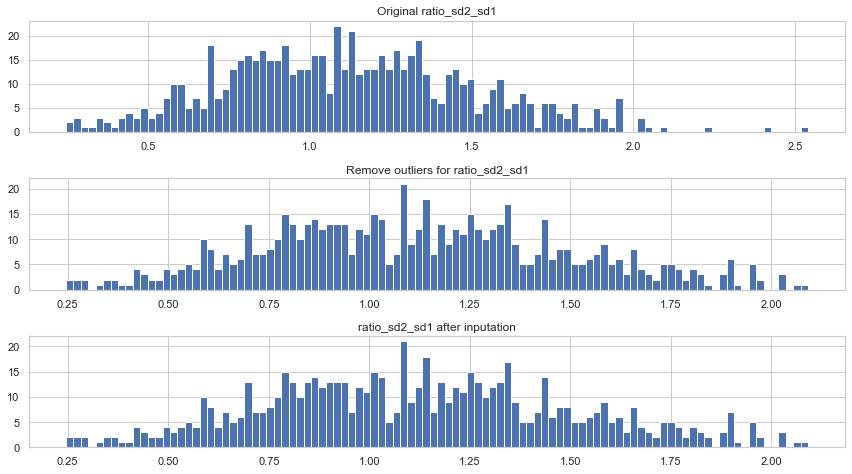

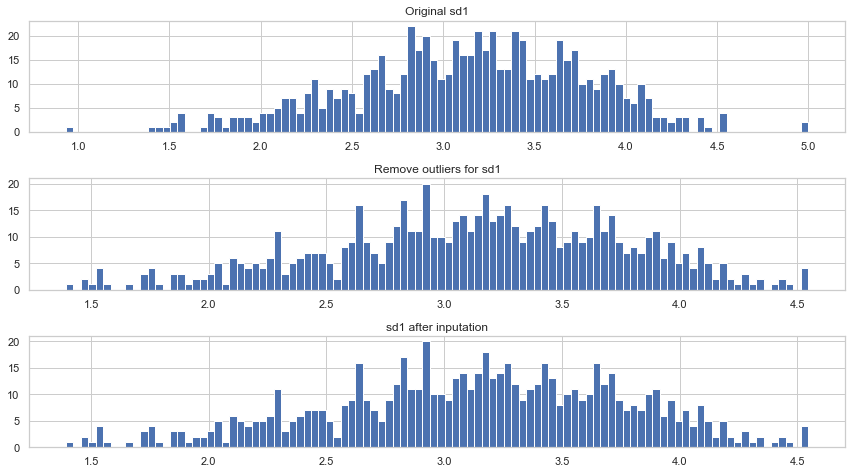

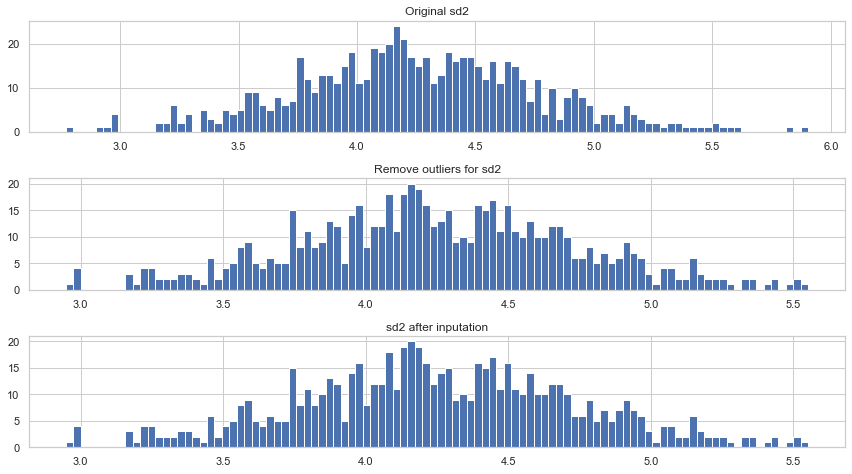

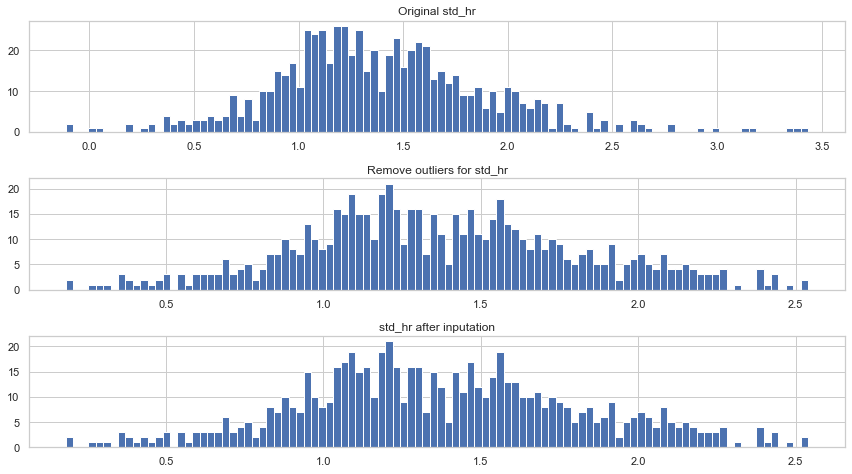

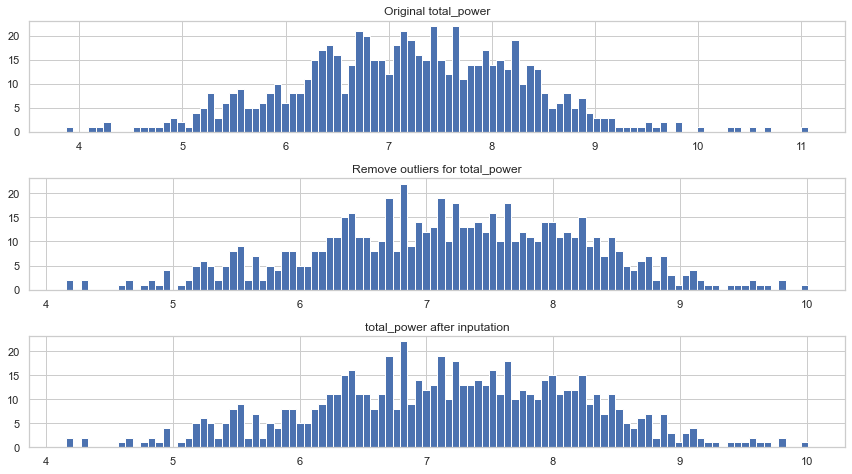

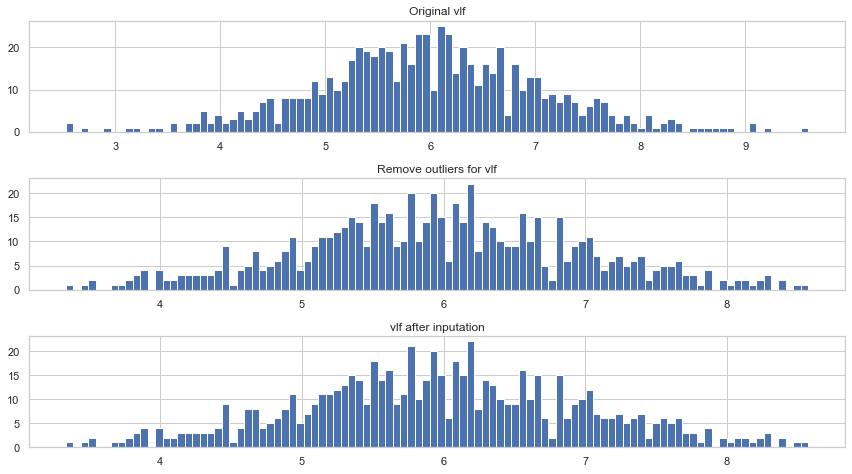

In [12]:
df = daily_records.loc[valid_hrv_measures,:].copy()

# HRV variables to clean (all but cv_lnrmssd, swc_lnrmssd, and max_hr)
hrv_clean_variables = ['lnrmssd', 'lnrmssd_ref_mean',
       'lnrmssd_ref_std', 'sdnn', 'sdsd', 'cvnni',
       'cvsd', 'hf', 'hfnu', 'lf', 'lf_hf_ratio', 'lfnu', 'mean_hr',
       'mean_nni', 'median_nni', 'min_hr', 'nni_20', 'nni_50', 'pnni_20',
       'pnni_50', 'range_nni', 'ratio_sd2_sd1', 'sd1', 'sd2', 'std_hr',
       'total_power', 'vlf',]

# SWC and CV are removed from the KNN replacement of IQR outliers 
# due to depending on time variances of lnrmssd 
# 'swc_lnrmssd', 'cv_lnrmssd',

# Only HRV and Wellness variables used to input KNN
knn_columns = ['lnrmssd', 'lnrmssd_ref_mean', 'lnrmssd_ref_std', 'swc_lnrmssd', 
       'cv_lnrmssd', 'sdnn', 'sdsd', 'cvnni', 'cvsd', 'hf', 'hfnu', 'lf', 
       'lf_hf_ratio', 'lfnu', 'max_hr', 'mean_hr', 'mean_nni', 'median_nni', 
       'min_hr', 'nni_20', 'nni_50', 'pnni_20', 'pnni_50', 'range_nni', 
       'ratio_sd2_sd1', 'sd1', 'sd2', 'std_hr', 'total_power', 'vlf', 
       'sleep_satisfaction', 'sleep_time', 'distress', 'recovery', 'fatigue',]

# outliers_summary = pd.Series()

for iqr_variable in hrv_clean_variables:
       knn_columns_selected = knn_columns.copy()
       if iqr_variable in knn_columns_selected:
              knn_columns_selected.remove(iqr_variable)
       
       input_data, outliers_index_in_original_data = replace_iqr_outliers_knn(data=df, iqr_variable=iqr_variable, knn_columns=knn_columns)
       if type(input_data) == pd.core.series.Series:
              daily_records.loc[outliers_index_in_original_data, iqr_variable] = input_data
              outliers_summary[iqr_variable] = len(outliers_index_in_original_data)
       else:
              outliers_summary[iqr_variable] = 0

outliers_summary

#### Chronic/Temporal Variables
SWC shows very high and very low values that do not make sense. Those outliers are redistributed in the tails as an uniform distribution. We consider that any difference higher than 3 times the SD are the same.

CV shows a long tail for lower values, but it is expectable, specially for early measurements before starting treatment/intervention. Those entries are not considered outliers neither modified.

array([[<AxesSubplot:title={'center':'swc_lnrmssd'}>,
        <AxesSubplot:title={'center':'cv_lnrmssd'}>]], dtype=object)

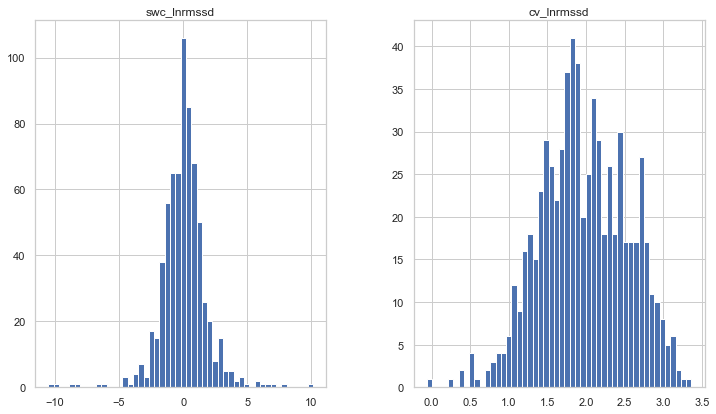

In [13]:
daily_records[['swc_lnrmssd', 'cv_lnrmssd']].hist(bins=50)

In [14]:
print('Q3+1.5std:')
print(daily_records['swc_lnrmssd'].quantile(0.75) + 1.5*daily_records['swc_lnrmssd'].std())
print('Q3+1std:')
print(daily_records['swc_lnrmssd'].quantile(0.75) + 1*daily_records['swc_lnrmssd'].std())

Q3+1.5std:
3.551955630707158
Q3+1std:
2.663437747276024


In [15]:
print('Q1-1.5*std:')
print(daily_records['swc_lnrmssd'].quantile(0.25) - 1.5*daily_records['swc_lnrmssd'].std())
print('Q1-1*std:')
print(daily_records['swc_lnrmssd'].quantile(0.25) - 1*daily_records['swc_lnrmssd'].std())

Q1-1.5*std:
-3.5297856284581948
Q1-1*std:
-2.6412677450270605


The far outliers on the right and the left may be misleading for the clustering, therefore, we redistribute those outliers in the edges of the tails. To maintain the balance, we replace those outliers with an uniform distribution of values between 2.5 and 3.5 (for the sake of interpreting the SWC, we consider that is the same to be outside the SWC for 2.5 standard deviations as for 3.5, 4.5, 5.5 and so on)

Outliers for swc_lnrmssd: 33
Outliers replaced for swc_lnrmssd: 33


max_hr              50
lnrmssd              3
lnrmssd_ref_mean     0
lnrmssd_ref_std     26
sdnn                 3
sdsd                 3
cvnni                8
cvsd                 5
hf                   1
hfnu                 4
lf                   9
lf_hf_ratio          3
lfnu                 0
mean_hr             17
mean_nni            10
median_nni          12
min_hr               8
nni_20               0
nni_50               4
pnni_20              0
pnni_50              9
range_nni            9
ratio_sd2_sd1        3
sd1                  3
sd2                  6
std_hr              19
total_power          6
vlf                 14
swc_lnrmssd         33
dtype: int64

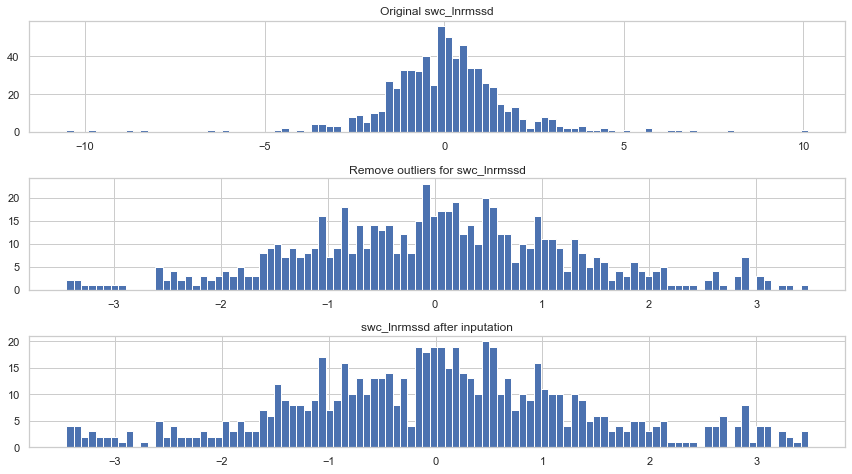

In [16]:
df = daily_records.loc[valid_hrv_measures,:].copy()

# HRV variables to clean
hrv_clean_variables = ['swc_lnrmssd']
thresholds = {'swc_lnrmssd':[-3.5, -2.5, 2.5, 3.5]}

# SWC and CV are removed from the KNN replacement of IQR outliers 
# due to depending on time variances of lnrmssd 
# 'swc_lnrmssd', 'cv_lnrmssd',

for iqr_variable in hrv_clean_variables:
       lower_range = thresholds[iqr_variable][0:2]
       upper_range = thresholds[iqr_variable][2:4]
       input_data, outliers_index_in_original_data = replace_iqr_outliers_uniform(data=df, iqr_variable=iqr_variable, lower_range=lower_range, upper_range=upper_range)
       if type(input_data) == pd.core.series.Series:
              daily_records.loc[outliers_index_in_original_data, iqr_variable] = input_data
              outliers_summary[iqr_variable] = len(outliers_index_in_original_data)
       else:
              outliers_summary[iqr_variable] = 0

outliers_summary

#### Summary of Outlier Inputation

In [17]:
d = pd.DataFrame(outliers_summary, columns=['n_outliers'])
d['percentage'] = 100*outliers_summary/(valid_hrv_measures.sum()).round(2)
print('Total samples')
print(valid_hrv_measures.sum())
d

Total samples
681


,n_outliers,percentage
max_hr,50,7.342144
lnrmssd,3,0.440529
lnrmssd_ref_mean,0,0.000000
lnrmssd_ref_std,26,3.817915
sdnn,3,0.440529
sdsd,3,0.440529
cvnni,8,1.174743
cvsd,5,0.734214
hf,1,0.146843
hfnu,4,0.587372


In [18]:
# print(d.round(2).to_latex())
print(d.round(2))

\begin{tabular}{lrr}
\toprule
{} &  n\_outliers &  percentage \\
\midrule
max\_hr           &          50 &        7.34 \\
lnrmssd          &           3 &        0.44 \\
lnrmssd\_ref\_mean &           0 &        0.00 \\
lnrmssd\_ref\_std  &          26 &        3.82 \\
sdnn             &           3 &        0.44 \\
sdsd             &           3 &        0.44 \\
cvnni            &           8 &        1.17 \\
cvsd             &           5 &        0.73 \\
hf               &           1 &        0.15 \\
hfnu             &           4 &        0.59 \\
lf               &           9 &        1.32 \\
lf\_hf\_ratio      &           3 &        0.44 \\
lfnu             &           0 &        0.00 \\
mean\_hr          &          17 &        2.50 \\
mean\_nni         &          10 &        1.47 \\
median\_nni       &          12 &        1.76 \\
min\_hr           &           8 &        1.17 \\
nni\_20           &           0 &        0.00 \\
nni\_50           &           4 &        0.59 \\
p

### Clean Wellness Data

#### Skewness

In [19]:
# Wellness skew
skewdf = pd.DataFrame(skewness_columns, columns=['skewness'])
print((skewdf.loc[['sleep_satisfaction', 'sleep_time', 'distress', 'recovery', 'fatigue',],:].round(2).to_latex()))

\begin{tabular}{lr}
\toprule
{} &  skewness \\
\midrule
sleep\_satisfaction &     -0.22 \\
sleep\_time         &     -0.10 \\
distress           &      1.03 \\
recovery           &      0.24 \\
fatigue            &     -0.44 \\
\bottomrule
\end{tabular}



#### Visual inspection

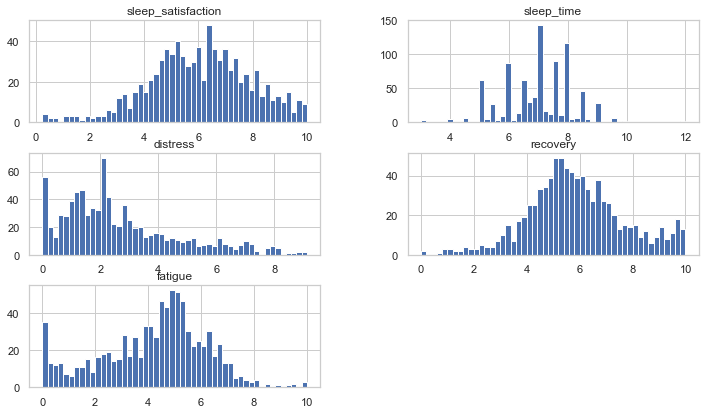

In [20]:
wellness_variables = ['sleep_satisfaction',
       'sleep_time', 'distress', 'recovery', 'fatigue']
daily_records[wellness_variables].hist(bins=50)

# After inspection, this is the one with skewness
column_skewness_wellness = ['distress']

#### Transform distress

In [21]:
# Replace 0 distress values with normal distribution between 0.0001 and 0.5001
distress_zero_index = (daily_records['distress'] == 0)

# Random value between 0.0001 and 0.5
np.random.seed(42)
distress_replacers = np.random.rand(distress_zero_index.sum())/2+0.0001

# Replace
daily_records.loc[distress_zero_index, 'distress'] = distress_replacers

<AxesSubplot:>

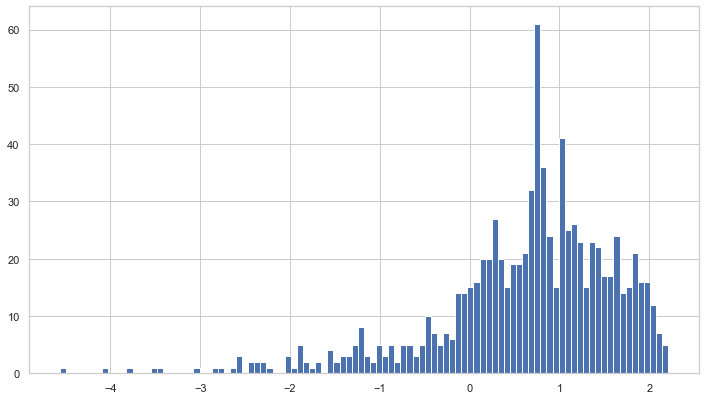

In [22]:
# Log transform for distress
daily_records['distress'] = daily_records['distress'].apply(np.log)
daily_records['distress'].hist(bins=100)

#### Outliers

Outliers for sleep_satisfaction: 6
Selected columns for sleep_satisfaction: ['lnrmssd', 'lnrmssd_ref_mean', 'lnrmssd_ref_std', 'swc_lnrmssd', 'cv_lnrmssd', 'sdnn', 'sdsd', 'cvnni', 'cvsd', 'hf', 'hfnu', 'lf', 'lf_hf_ratio', 'lfnu', 'max_hr', 'mean_hr', 'mean_nni', 'median_nni', 'min_hr', 'nni_20', 'nni_50', 'pnni_20', 'pnni_50', 'range_nni', 'ratio_sd2_sd1', 'sd1', 'sd2', 'std_hr', 'total_power', 'vlf', 'sleep_time', 'distress', 'recovery', 'fatigue']
Outliers replaced for sleep_satisfaction: 6
Outliers for sleep_time: 4
Selected columns for sleep_time: ['lnrmssd', 'lnrmssd_ref_mean', 'lnrmssd_ref_std', 'swc_lnrmssd', 'cv_lnrmssd', 'sdnn', 'sdsd', 'cvnni', 'cvsd', 'hf', 'hfnu', 'lf', 'lf_hf_ratio', 'lfnu', 'max_hr', 'mean_hr', 'mean_nni', 'median_nni', 'min_hr', 'nni_20', 'nni_50', 'pnni_20', 'pnni_50', 'range_nni', 'ratio_sd2_sd1', 'sd1', 'sd2', 'std_hr', 'total_power', 'vlf', 'sleep_satisfaction', 'distress', 'recovery', 'fatigue']
Outliers replaced for sleep_time: 4
Outliers for dis

max_hr                50
lnrmssd                3
lnrmssd_ref_mean       0
lnrmssd_ref_std       26
sdnn                   3
sdsd                   3
cvnni                  8
cvsd                   5
hf                     1
hfnu                   4
lf                     9
lf_hf_ratio            3
lfnu                   0
mean_hr               17
mean_nni              10
median_nni            12
min_hr                 8
nni_20                 0
nni_50                 4
pnni_20                0
pnni_50                9
range_nni              9
ratio_sd2_sd1          3
sd1                    3
sd2                    6
std_hr                19
total_power            6
vlf                   14
swc_lnrmssd           33
sleep_satisfaction     6
sleep_time             4
distress              33
recovery              15
fatigue                5
dtype: int64

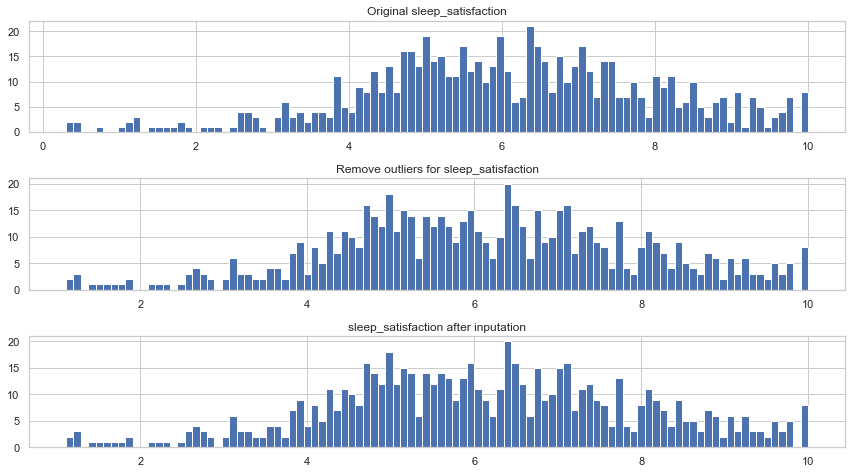

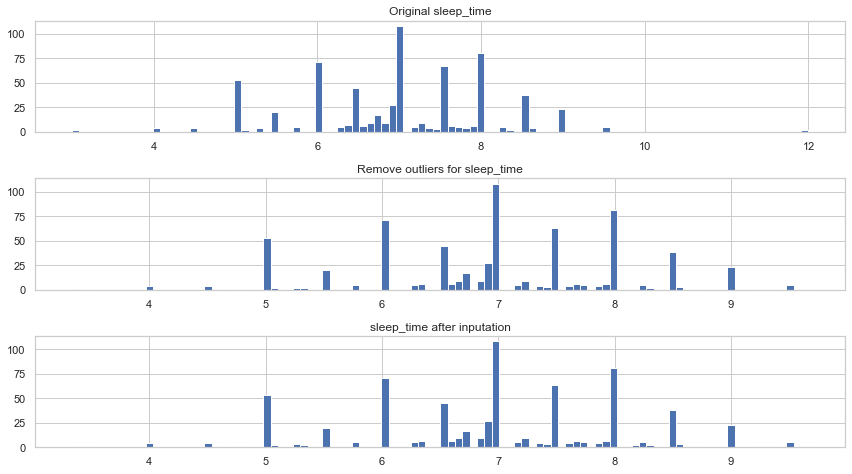

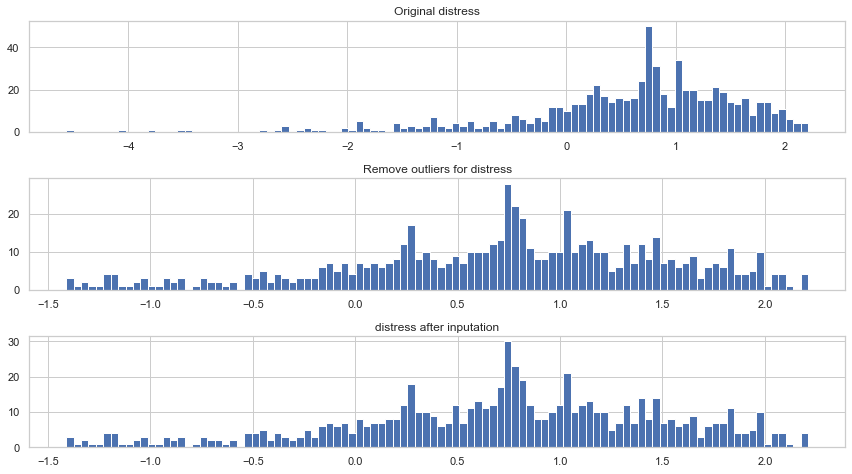

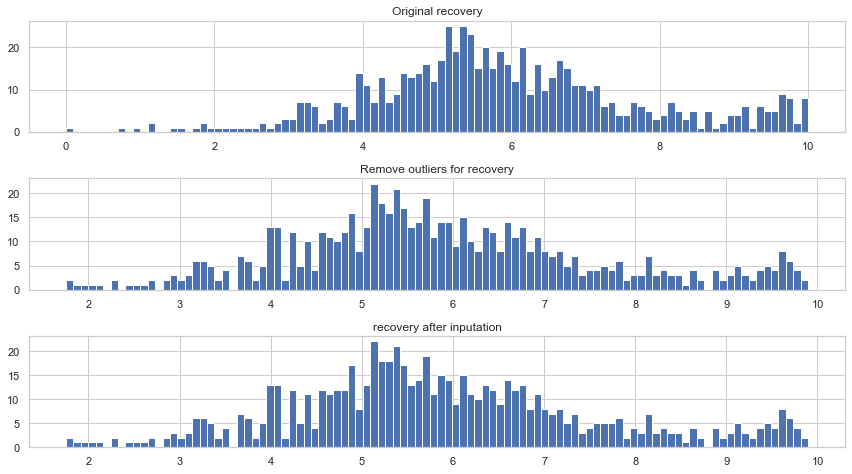

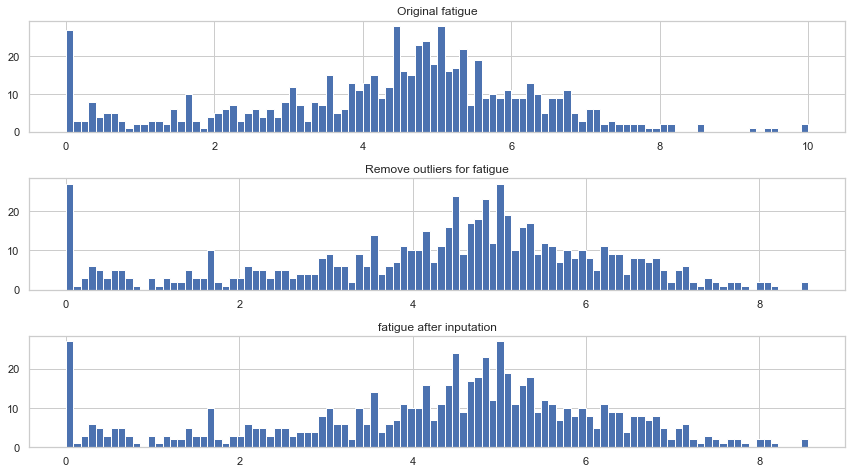

In [23]:
df = daily_records.loc[valid_hrv_measures,:].copy()

# HRV variables to clean (all but cv_lnrmssd, swc_lnrmssd, and max_hr)
wellness_clean_variables = ['sleep_satisfaction',
       'sleep_time', 'distress', 'recovery', 'fatigue']

# SWC and CV are removed from the KNN replacement of IQR outliers 
# due to depending on time variances of lnrmssd 
# 'swc_lnrmssd', 'cv_lnrmssd',

# Only HRV and Wellness variables used to input KNN
knn_columns = ['lnrmssd', 'lnrmssd_ref_mean', 'lnrmssd_ref_std', 'swc_lnrmssd', 
       'cv_lnrmssd', 'sdnn', 'sdsd', 'cvnni', 'cvsd', 'hf', 'hfnu', 'lf', 
       'lf_hf_ratio', 'lfnu', 'max_hr', 'mean_hr', 'mean_nni', 'median_nni', 
       'min_hr', 'nni_20', 'nni_50', 'pnni_20', 'pnni_50', 'range_nni', 
       'ratio_sd2_sd1', 'sd1', 'sd2', 'std_hr', 'total_power', 'vlf', 
       'sleep_satisfaction', 'sleep_time', 'distress', 'recovery', 'fatigue',]

# outliers_summary = pd.Series()

for iqr_variable in wellness_clean_variables:
       knn_columns_selected = knn_columns.copy()
       if iqr_variable in knn_columns_selected:
              knn_columns_selected.remove(iqr_variable)
       
       input_data, outliers_index_in_original_data = replace_iqr_outliers_knn(data=df, iqr_variable=iqr_variable, knn_columns=knn_columns)
       if type(input_data) == pd.core.series.Series:
              daily_records.loc[outliers_index_in_original_data, iqr_variable] = input_data
              outliers_summary[iqr_variable] = len(outliers_index_in_original_data)
       else:
              outliers_summary[iqr_variable] = 0

outliers_summary

#### Z-scored wellness

In [24]:
# Standardization (zero mean and unit variance)
from sklearn import preprocessing

columns_questions = ['sleep_satisfaction', 'sleep_time', 'distress', 'recovery',
       'fatigue']
columns_questions_zscored = [name + '_zscored' for name in columns_questions]

for u in daily_records['username'].unique():
    # Filter data
    user_index = daily_records['username']==u
    df_loop = daily_records.loc[user_index, ['username'] + columns_questions]
    
    # Transform
    scaler = preprocessing.StandardScaler().fit(df_loop.drop('username', axis=1).values)
    df_standardized_loop = scaler.transform(df_loop.drop('username', axis=1).values)

    # DF and change names
    daily_records.loc[df_loop.index, columns_questions_zscored] = df_standardized_loop


/home/dollo/Workspace/atope-analysis/venv/lib/python3.6/site-packages/sklearn/utils/extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/dollo/Workspace/atope-analysis/venv/lib/python3.6/site-packages/sklearn/utils/extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


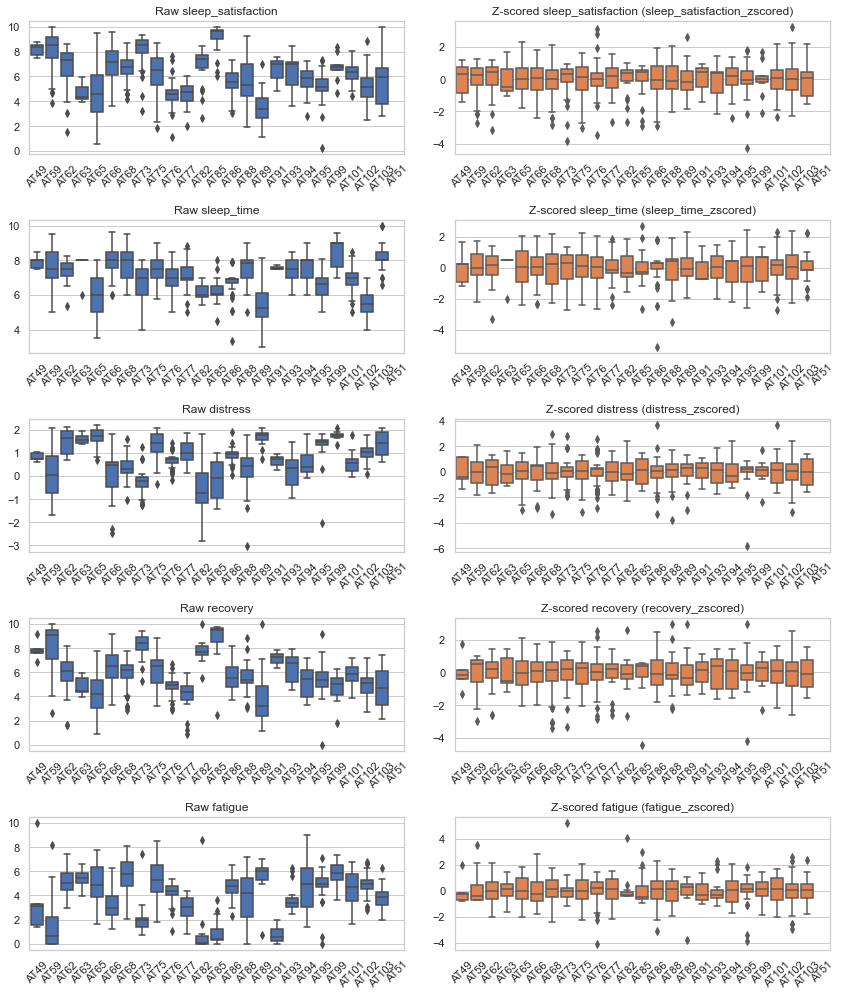

In [25]:
# Plot wellness vs zscored wellness 
fig, axes = plt.subplots(5,2, figsize=(12,14))
i=0
for column in columns_questions:
       ax = axes[i,0]
       sns.boxplot(x='username', y=column, data=daily_records,
              color='C0',
              saturation=1, ax=ax)
       _ = ax.set_xlabel('')
       _ = ax.set_ylabel('')
       _ = ax.tick_params('x', rotation=45)
       _ = ax.set_title('Raw '+column)
       i = i+1
i = 0
for column in columns_questions_zscored:
       ax = axes[i,1]
       sns.boxplot(x='username', y=column, data=daily_records,
              color='C1',
              saturation=1, ax=ax)
       _ = ax.set_xlabel('')
       _ = ax.set_ylabel('')
       _ = ax.tick_params('x', rotation=45)
       _ = ax.set_title('Z-scored '+column[:-8]+' ('+column+')')
       i = i+1

fig.tight_layout()
fig.savefig('viz/wellness-normalization.pdf', bbox_inches='tight')

#### Summary of Outlier Inputation

In [26]:
d = pd.DataFrame(outliers_summary, columns=['n_outliers'])
d['percentage'] = 100*outliers_summary/(valid_hrv_measures.sum()).round(2)
print('Total samples')
print(valid_hrv_measures.sum())
d

Total samples
681


,n_outliers,percentage
max_hr,50,7.342144
lnrmssd,3,0.440529
lnrmssd_ref_mean,0,0.000000
lnrmssd_ref_std,26,3.817915
sdnn,3,0.440529
sdsd,3,0.440529
cvnni,8,1.174743
cvsd,5,0.734214
hf,1,0.146843
hfnu,4,0.587372


In [27]:
# print(d.round(2).to_latex())
print(d.round(2))

\begin{tabular}{lrr}
\toprule
{} &  n\_outliers &  percentage \\
\midrule
max\_hr             &          50 &        7.34 \\
lnrmssd            &           3 &        0.44 \\
lnrmssd\_ref\_mean   &           0 &        0.00 \\
lnrmssd\_ref\_std    &          26 &        3.82 \\
sdnn               &           3 &        0.44 \\
sdsd               &           3 &        0.44 \\
cvnni              &           8 &        1.17 \\
cvsd               &           5 &        0.73 \\
hf                 &           1 &        0.15 \\
hfnu               &           4 &        0.59 \\
lf                 &           9 &        1.32 \\
lf\_hf\_ratio        &           3 &        0.44 \\
lfnu               &           0 &        0.00 \\
mean\_hr            &          17 &        2.50 \\
mean\_nni           &          10 &        1.47 \\
median\_nni         &          12 &        1.76 \\
min\_hr             &           8 &        1.17 \\
nni\_20             &           0 &        0.00 \\
nni\_50       

### Clean Fitbit data
Normal like-distributions (all steps and sleep data)


#### Visual inspection
Zeroes need to be removed/cleaned, only moderate and vigorous physical activity seem to need some transformation.

In [28]:
# Sleep classic and stage categories are defined here https://dev.fitbit.com/build/reference/web-api/sleep/get-sleep-log-by-date/
# Classic type are only measured in the beginning for calibration in the first 4-7 days, then it switches to stage, thus are removed from analysis, (total sleep time is kept).
# Unknown is also removed due to low presence in data (few entries different than 0)
columns_fitbit_sleep_classic = ['sleep_asleep', 'sleep_awake', 'sleep_restless', 
    'sleep_unknown']
columns_fitbit_sleep_stage = ['sleep_deep', 'sleep_light', 'sleep_rem', 
    'sleep_wake', 'sleep_total']

# Also define steps columns for later use. Steps today are removed since the
# last available steps yuu would have are the steps from yesterday
columns_fitbit_steps_yesterday = ['steps_light_yesterday', 
       'steps_moderate_yesterday', 'steps_sedentary_yesterday', 
       'steps_total_yesterday', 'steps_vigorous_yesterday']

columns_fitbit_steps_today = ['steps_light', 'steps_moderate',
       'steps_sedentary', 'steps_total', 'steps_vigorous']

# Since last steps data would be yesterday, we drop "steps today" columns 
# defined before (keep only sleep yesterday)

daily_records = daily_records.drop(columns=columns_fitbit_steps_today)
# daily_records = daily_records.drop(columns=columns_fitbit_sleep_classic)

array([[<AxesSubplot:title={'center':'sleep_deep'}>,
        <AxesSubplot:title={'center':'sleep_light'}>,
        <AxesSubplot:title={'center':'sleep_rem'}>],
       [<AxesSubplot:title={'center':'sleep_wake'}>,
        <AxesSubplot:title={'center':'sleep_total'}>,
        <AxesSubplot:title={'center':'steps_light_yesterday'}>],
       [<AxesSubplot:title={'center':'steps_moderate_yesterday'}>,
        <AxesSubplot:title={'center':'steps_sedentary_yesterday'}>,
        <AxesSubplot:title={'center':'steps_total_yesterday'}>],
       [<AxesSubplot:title={'center':'steps_vigorous_yesterday'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

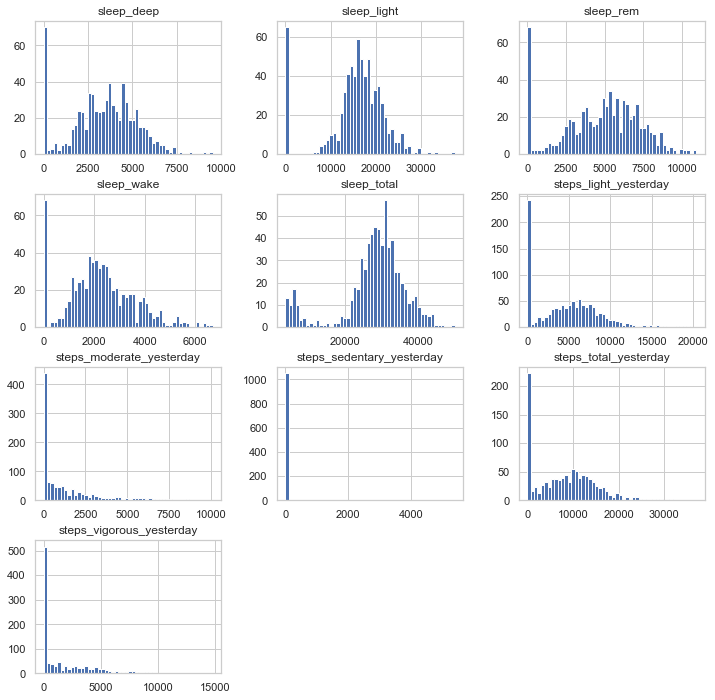

In [29]:
# Plot
daily_records[columns_fitbit_sleep_stage+columns_fitbit_steps_yesterday].hist(bins=50, figsize=(12, 12))

#### Sleep
There is a high number of entries equal to zero for classic sleep variables. This is because this variables are only used during the first nights of sleep, while the Fitbit algorithm gets trained. Once it has finished (after 4-5 nights of sleep), the API automatically delivers "staged" sleep. Hence, classic sleep variables are removed.

In [31]:
# Print number of sleep entries equal to zero
print('Sleep entries equal to 0:')
print((daily_records[columns_fitbit_sleep_classic+columns_fitbit_sleep_stage]==0).sum())

# Drop classic sleep columns (keep stage sleep)
daily_records = daily_records.drop(columns=columns_fitbit_sleep_classic)

Sleep entries equal to 0:
sleep_asleep      490
sleep_awake       613
sleep_restless    510
sleep_unknown     682
sleep_deep         70
sleep_light        65
sleep_rem          68
sleep_wake         67
sleep_total         0
dtype: int64


Outliers for sleep_deep: 3
Selected columns for sleep_deep: ['cv_lnrmssd', 'max_hr', 'mean_hr', 'min_hr', 'lnrmssd_ref_mean', 'lnrmssd_ref_std', 'sleep_light', 'sleep_rem', 'sleep_wake', 'sleep_total', 'steps_light_yesterday', 'steps_moderate_yesterday', 'steps_sedentary_yesterday', 'steps_total_yesterday', 'steps_vigorous_yesterday']
Outliers replaced for sleep_deep: 3
Outliers for sleep_light: 7
Selected columns for sleep_light: ['sleep_deep', 'sleep_rem', 'sleep_wake', 'sleep_total', 'steps_light_yesterday', 'steps_moderate_yesterday', 'steps_sedentary_yesterday', 'steps_total_yesterday', 'steps_vigorous_yesterday']
Outliers replaced for sleep_light: 7
Outliers for sleep_rem: 0
Outliers for sleep_wake: 12
Selected columns for sleep_wake: ['sleep_deep', 'sleep_light', 'sleep_rem', 'sleep_total', 'steps_light_yesterday', 'steps_moderate_yesterday', 'steps_sedentary_yesterday', 'steps_total_yesterday', 'steps_vigorous_yesterday']
Outliers replaced for sleep_wake: 12
Outliers for sleep_

max_hr                50
lnrmssd                3
lnrmssd_ref_mean       0
lnrmssd_ref_std       26
sdnn                   3
sdsd                   3
cvnni                  8
cvsd                   5
hf                     1
hfnu                   4
lf                     9
lf_hf_ratio            3
lfnu                   0
mean_hr               17
mean_nni              10
median_nni            12
min_hr                 8
nni_20                 0
nni_50                 4
pnni_20                0
pnni_50                9
range_nni              9
ratio_sd2_sd1          3
sd1                    3
sd2                    6
std_hr                19
total_power            6
vlf                   14
swc_lnrmssd           33
sleep_satisfaction     6
sleep_time             4
distress              33
recovery              15
fatigue                5
sleep_deep             3
sleep_light            7
sleep_rem              0
sleep_wake            12
sleep_total           16
dtype: int64

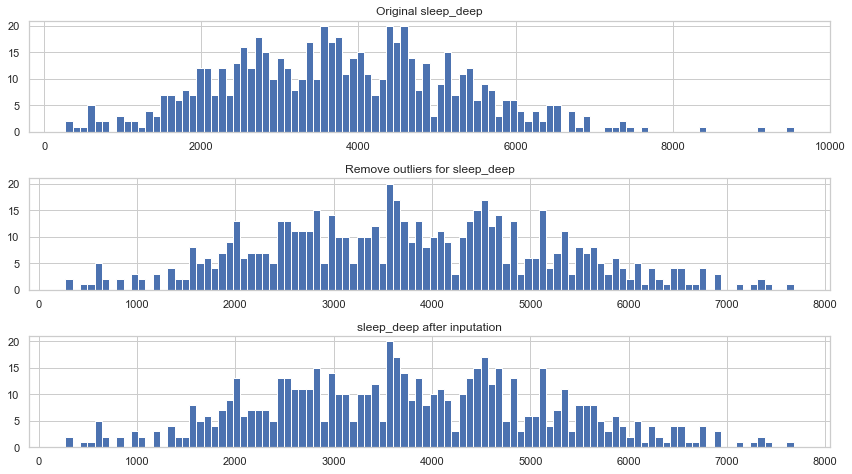

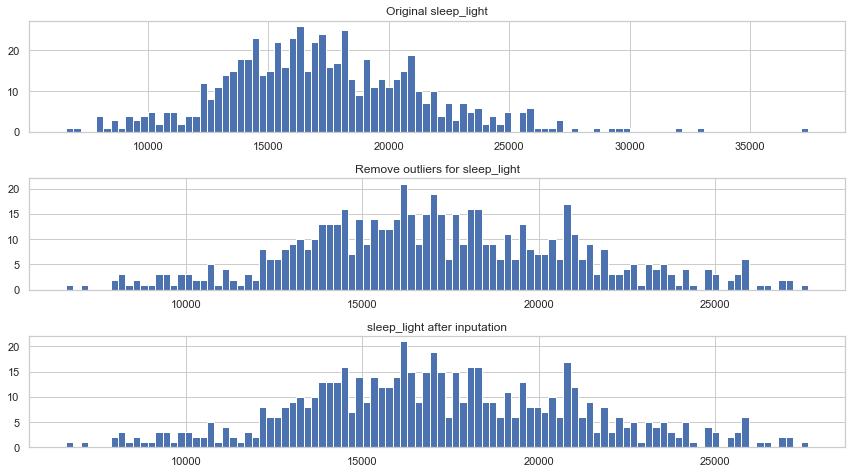

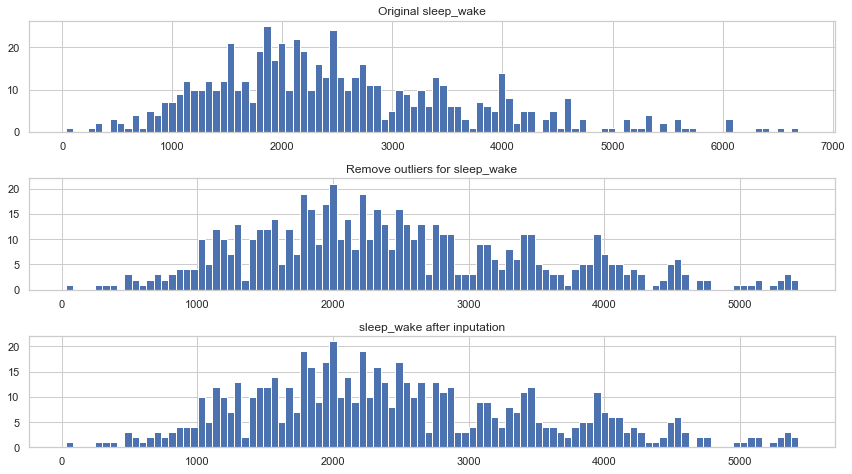

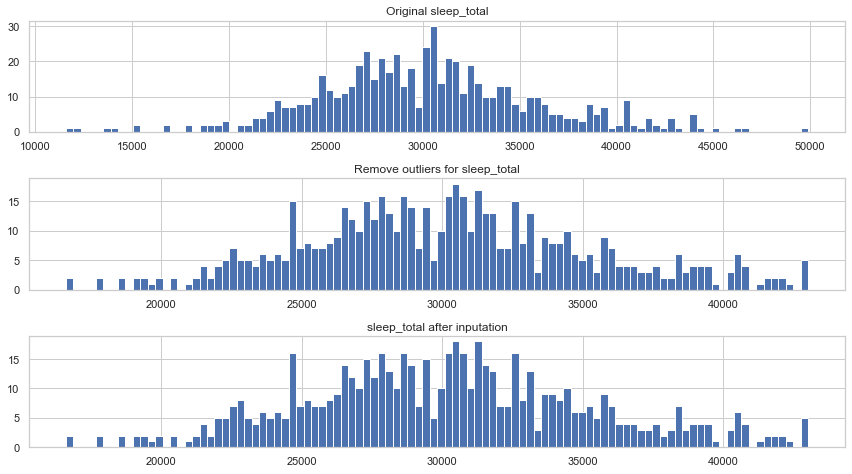

In [32]:
# Fitbit variables to clean
columns_to_clean_fitbit_sleep = ['sleep_deep', 'sleep_light', 'sleep_rem', 
    'sleep_wake', 'sleep_total']

# The following variables cannot have 0 values to be valid
columns_nonzero_fitbit_sleep = ['sleep_total','sleep_light']

# Set to nan all sleep measure in which "nonzero" columns are zero
index_zeroes = (daily_records.loc[:,columns_nonzero_fitbit_sleep]==0).any(axis=1)
daily_records.loc[index_zeroes, columns_to_clean_fitbit_sleep]=np.nan

# Work on copy for safety
df = daily_records.copy()
df = df[df.loc[:,'sleep_total'].notna()]

# Entries with 0 in normal-like sleep columns are set to zero for IQR outliers replacement. 
# This removes skew when interpreting the data as a normal distributions (they are another case).
df[(df.loc[:,columns_to_clean_fitbit_sleep]==0)]=np.nan
df[(df.loc[:,columns_to_clean_fitbit_sleep]==np.inf)]=np.nan
df[(df.loc[:,columns_to_clean_fitbit_sleep]==-np.inf)]=np.nan

# Only Fitbit and some HRV chronic variables, used to input KNN
knn_columns = ['cv_lnrmssd', 'max_hr', 'mean_hr', 'min_hr', 'lnrmssd_ref_mean', 'lnrmssd_ref_std'] + columns_fitbit_sleep_stage + columns_fitbit_steps_yesterday

for iqr_variable in columns_to_clean_fitbit_sleep:
       knn_columns_selected = knn_columns.copy()
       if iqr_variable in knn_columns_selected:
              knn_columns_selected.remove(iqr_variable)
       
       input_data, outliers_index_in_original_data = replace_iqr_outliers_knn(data=df, iqr_variable=iqr_variable, knn_columns=knn_columns)
       if type(input_data) == pd.core.series.Series:
              daily_records.loc[outliers_index_in_original_data, iqr_variable] = input_data
              outliers_summary[iqr_variable] = len(outliers_index_in_original_data)
       else:
              outliers_summary[iqr_variable] = 0

outliers_summary

#### Steps
Steps are corrected too. Only moderate and vigorous need to be transformed, but all are cleaned.

In [33]:
# Keep steps for yesterday only
# daily_records = daily_records.drop(['steps_light', 'steps_moderate', 
#                                     'steps_sedentary', 'steps_total',
#                                     'steps_vigorous'], axis=1)

In [34]:
# Steps sedentary yesterday has a very low number of entries greater than zero, thus it is removed
print('number of steps entries greater than 0:' )
print((daily_records[columns_fitbit_steps_yesterday]>0).sum())

# Drop sedentary steps column
columns_fitbit_steps_yesterday.remove('steps_sedentary_yesterday')
daily_records = daily_records.drop(columns=['steps_sedentary_yesterday'])

number of steps entries greater than 0:
steps_light_yesterday        843
steps_moderate_yesterday     663
steps_sedentary_yesterday     30
steps_total_yesterday        843
steps_vigorous_yesterday     611
dtype: int64


In [35]:
print('number of steps entries == 0:' )
print((daily_records[columns_fitbit_steps_yesterday]==0).sum())

number of steps entries == 0:
steps_light_yesterday       229
steps_moderate_yesterday    409
steps_total_yesterday       204
steps_vigorous_yesterday    461
dtype: int64


In [36]:
# Fitbit variables to clean
columns_to_clean_fitbit_steps = ['steps_light_yesterday',
       'steps_moderate_yesterday',
       'steps_total_yesterday', 'steps_vigorous_yesterday']

# The following variables cannot have 0 values to be valid
columns_nonzero_fitbit_steps = ['steps_total_yesterday']

# Set to nan all sleep measure in which "nonzero" columns are zero
index_zeroes = (daily_records.loc[:,columns_nonzero_fitbit_steps]==0).any(axis=1)
daily_records.loc[index_zeroes, columns_to_clean_fitbit_steps]=np.nan

# Now work on copy for safety
df = daily_records.copy()
df = df[df.loc[:,'steps_total_yesterday'].notna()]

# Entries with 0 in normal-like sleep columns are set to zero for IQR outliers replacement. 
# This removes skew when interpreting the data as a normal distributions (they are another case).
df[(df.loc[:,columns_to_clean_fitbit_steps]==0)]=np.nan
df[(df.loc[:,columns_to_clean_fitbit_steps]==np.inf)]=np.nan
df[(df.loc[:,columns_to_clean_fitbit_steps]==-np.inf)]=np.nan

steps_light_yesterday       1.009902
steps_moderate_yesterday    1.370463
steps_vigorous_yesterday    1.181364
dtype: float64
Index(['steps_light_yesterday', 'steps_moderate_yesterday',
       'steps_vigorous_yesterday'],
      dtype='object')


array([[<AxesSubplot:title={'center':'steps_light_yesterday'}>,
        <AxesSubplot:title={'center':'steps_moderate_yesterday'}>],
       [<AxesSubplot:title={'center':'steps_total_yesterday'}>,
        <AxesSubplot:title={'center':'steps_vigorous_yesterday'}>]],
      dtype=object)

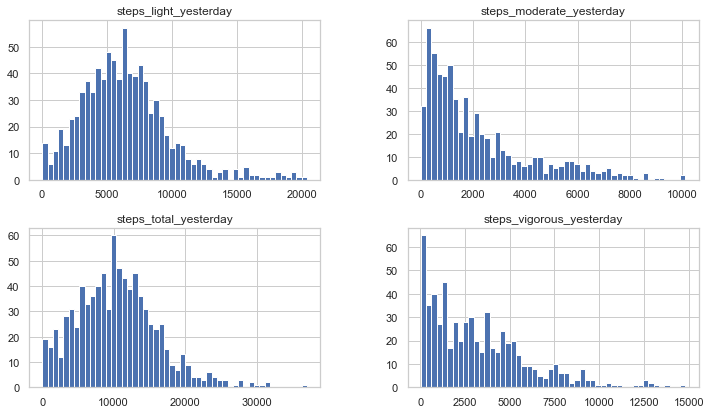

In [37]:
# Compute skew
skewness_columns = df[columns_to_clean_fitbit_steps].apply(lambda srs: skew(srs.dropna()))

print(skewness_columns[(skewness_columns>1) | (skewness_columns<-1)])
print(skewness_columns[(skewness_columns>1) | (skewness_columns<-1)].index)

df[columns_to_clean_fitbit_steps].hist(bins=50)
# df[columns_to_clean_fitbit_steps].apply(np.log).hist(bins=50)

# Transforming the data to np.log with low skew would switch the tail from higher
# to lower values. Very high number of steps are more likely to be an outlier 
# than very low number of steps at any stage. 

In [38]:
# Compute skew
skewness_columns = df[columns_to_clean_fitbit_steps+columns_to_clean_fitbit_sleep].apply(lambda srs: skew(srs.dropna()))

# print(skewness_columns[(skewness_columns>1) | (skewness_columns<-1)])
# print(skewness_columns[(skewness_columns>1) | (skewness_columns<-1)].index)

# print(skewness_columns.round(2).to_latex())
print(skewness_columns.round(2))

\begin{tabular}{lr}
\toprule
{} &     0 \\
\midrule
steps\_light\_yesterday    &  1.01 \\
steps\_moderate\_yesterday &  1.37 \\
steps\_total\_yesterday    &  0.68 \\
steps\_vigorous\_yesterday &  1.18 \\
sleep\_deep               &  0.00 \\
sleep\_light              &  0.13 \\
sleep\_rem                & -0.06 \\
sleep\_wake               &  0.49 \\
sleep\_total              &  0.19 \\
\bottomrule
\end{tabular}



array([[<AxesSubplot:title={'center':'steps_light_yesterday'}>,
        <AxesSubplot:title={'center':'steps_moderate_yesterday'}>],
       [<AxesSubplot:title={'center':'steps_total_yesterday'}>,
        <AxesSubplot:title={'center':'steps_vigorous_yesterday'}>]],
      dtype=object)

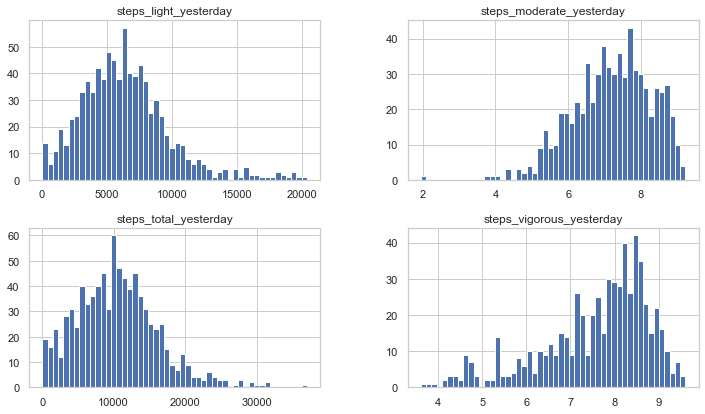

In [39]:
df['steps_moderate_yesterday'] = df['steps_moderate_yesterday'].apply(np.log)
df['steps_vigorous_yesterday'] = df['steps_vigorous_yesterday'].apply(np.log)
df[columns_to_clean_fitbit_steps].hist(bins=50)

Outliers for steps_light_yesterday: 29
Selected columns for steps_light_yesterday: ['steps_total_yesterday']
Outliers replaced for steps_light_yesterday: 29
Outliers for steps_moderate_yesterday: 4
Selected columns for steps_moderate_yesterday: ['steps_light_yesterday', 'steps_total_yesterday']
Outliers replaced for steps_moderate_yesterday: 4
Outliers for steps_total_yesterday: 14
Selected columns for steps_total_yesterday: ['steps_light_yesterday', 'steps_moderate_yesterday', 'steps_vigorous_yesterday']
Outliers replaced for steps_total_yesterday: 14
Outliers for steps_vigorous_yesterday: 21
Selected columns for steps_vigorous_yesterday: ['steps_light_yesterday', 'steps_moderate_yesterday', 'steps_total_yesterday']
Outliers replaced for steps_vigorous_yesterday: 21


max_hr                      50
lnrmssd                      3
lnrmssd_ref_mean             0
lnrmssd_ref_std             26
sdnn                         3
sdsd                         3
cvnni                        8
cvsd                         5
hf                           1
hfnu                         4
lf                           9
lf_hf_ratio                  3
lfnu                         0
mean_hr                     17
mean_nni                    10
median_nni                  12
min_hr                       8
nni_20                       0
nni_50                       4
pnni_20                      0
pnni_50                      9
range_nni                    9
ratio_sd2_sd1                3
sd1                          3
sd2                          6
std_hr                      19
total_power                  6
vlf                         14
swc_lnrmssd                 33
sleep_satisfaction           6
sleep_time                   4
distress                    33
recovery

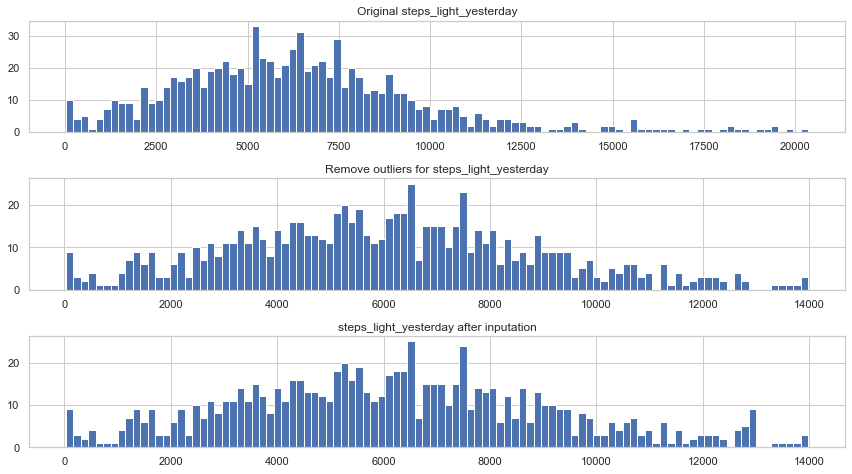

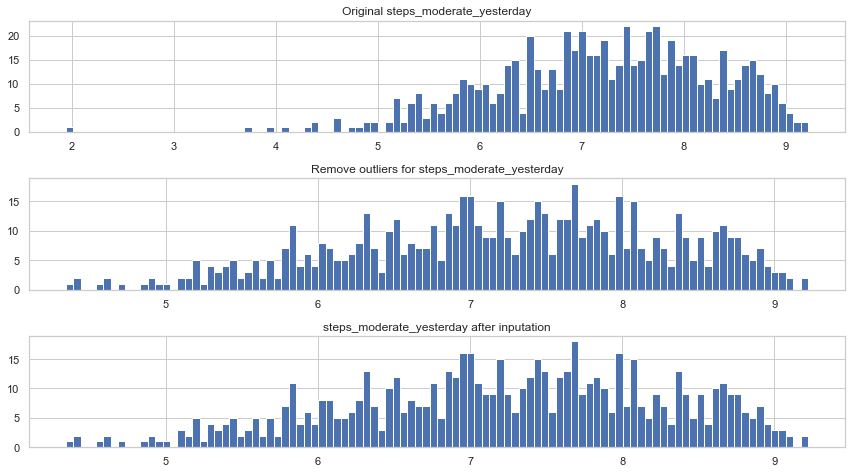

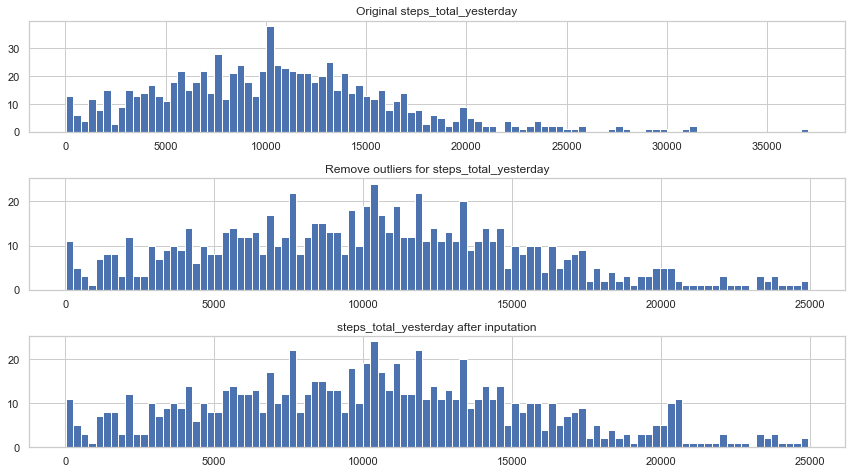

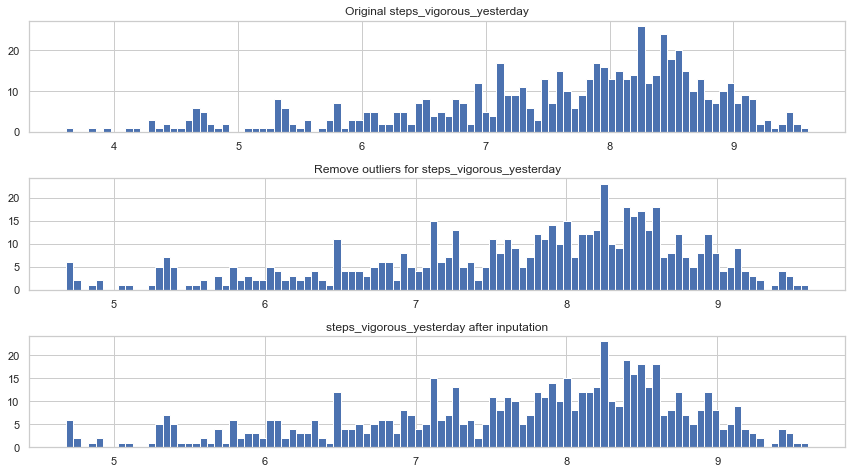

In [40]:
# Only Fitbit and some HRV chronic variables, used to input KNN
knn_columns = ['cv_lnrmssd', 'max_hr', 'mean_hr', 'min_hr', 'lnrmssd_ref_mean', 'lnrmssd_ref_std'] + columns_fitbit_sleep_stage + columns_fitbit_steps_yesterday

for iqr_variable in columns_to_clean_fitbit_steps:
        knn_columns_selected = knn_columns.copy()
        if iqr_variable in knn_columns_selected:
                knn_columns_selected.remove(iqr_variable)
        
        input_data, outliers_index_in_original_data = replace_iqr_outliers_knn(data=df, iqr_variable=iqr_variable, knn_columns=knn_columns)
        if type(input_data) == pd.core.series.Series:
            daily_records.loc[outliers_index_in_original_data, iqr_variable] = input_data
            outliers_summary[iqr_variable] = len(outliers_index_in_original_data)
        else:
            outliers_summary[iqr_variable] = 0

outliers_summary

#### Summary of Outlier Inputation

In [41]:
d = pd.DataFrame(outliers_summary, columns=['n_outliers'])
d['percentage'] = 100*outliers_summary/(valid_hrv_measures.sum()).round(2)
print('Total samples')
print(valid_hrv_measures.sum())
d

Total samples
681


,n_outliers,percentage
max_hr,50,7.342144
lnrmssd,3,0.440529
lnrmssd_ref_mean,0,0.000000
lnrmssd_ref_std,26,3.817915
sdnn,3,0.440529
sdsd,3,0.440529
cvnni,8,1.174743
cvsd,5,0.734214
hf,1,0.146843
hfnu,4,0.587372


In [42]:
# print(d.round(2).to_latex())
print(d.round(2))

\begin{tabular}{lrr}
\toprule
{} &  n\_outliers &  percentage \\
\midrule
max\_hr                   &          50 &        7.34 \\
lnrmssd                  &           3 &        0.44 \\
lnrmssd\_ref\_mean         &           0 &        0.00 \\
lnrmssd\_ref\_std          &          26 &        3.82 \\
sdnn                     &           3 &        0.44 \\
sdsd                     &           3 &        0.44 \\
cvnni                    &           8 &        1.17 \\
cvsd                     &           5 &        0.73 \\
hf                       &           1 &        0.15 \\
hfnu                     &           4 &        0.59 \\
lf                       &           9 &        1.32 \\
lf\_hf\_ratio              &           3 &        0.44 \\
lfnu                     &           0 &        0.00 \\
mean\_hr                  &          17 &        2.50 \\
mean\_nni                 &          10 &        1.47 \\
median\_nni               &          12 &        1.76 \\
min\_hr             

## Save clean data

In [43]:
daily_records.to_csv('./data/atope+breast/records-clean.csv', index=False)
demographics.to_csv('./data/atope+breast/demographics-clean.csv', index=False)